In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

In [ ]:
# Configuration and parameters
DATA_FOLDER = "/content/drive/MyDrive/Random/Hiroshima/ABC2025/Test"
USER_IDS = ["T1N01", "T1F01", "T1S01", "T1S02"]  # train data ID
FS = 33  # Sampling rate

# Action label encoding mapping
action_mapping = {
    "Explanation to patient": 0,
    "Confirm necessary items": 1,
    "Disinfect hands": 2,
    "Wearing gloves": 3,
    "Prepare the nutrition solution": 4,
    "Check the gastrostomy site": 5,
    "Open the gastrostomy cap": 6,
    "Inject lukewarm water": 7,
    "Connect the nutrition tube": 8,
    "Adjust the infusion rate": 9,
    "Removal of gloves": 10,
    "Prepare lukewarm water": 11,
    "Close the clamp": 12,
    "Disconnect the nutrition tube": 13,
    "Close the gastrostomy cap": 14,
    "Clean up used items": 15,
    "Others": 16
}

# Create a list to store all user data
all_kp_data = []
all_ann_data = []

# Load and clean each user's data
for user_id in USER_IDS:
    keypoint_csv = f"{DATA_FOLDER}/Body_KeyPoint_CSV/Front_{user_id}.csv"
    ann_csv = f"{DATA_FOLDER}/Annotation_CSV/Front_{user_id}.csv"

    # Load data
    kp_df = pd.read_csv(keypoint_csv).loc[:, ~pd.read_csv(keypoint_csv).columns.str.contains('^Unnamed')]
    ann_df = pd.read_csv(ann_csv).loc[:, ~pd.read_csv(ann_csv).columns.str.contains('^Unnamed')]

    # Clean up redundant columns
    kp_df = kp_df.loc[:, ~kp_df.columns.str.contains('Frame|conf|left_knee|right_knee|left_ankle|right_ankle', regex=True)]

    # Store in a list
    all_kp_data.append(kp_df)
    all_ann_data.append(ann_df)

print("Loaded and cleaned data for all users.")

Loaded and cleaned data for all users.


In [ ]:
SMOOTH_LEN = 3  # Smoothing length, in seconds

def smooth_kp(kp_col):
    zero_idx = np.flatnonzero(kp_col == 0)
    split_idx = np.split(zero_idx, np.flatnonzero(np.diff(zero_idx) > 1) + 1)
    for each_split_idx in split_idx:
        if len(each_split_idx) == 0 or each_split_idx[0] == 0 or each_split_idx[-1] == (len(kp_col) - 1) or len(each_split_idx) > SMOOTH_LEN * FS:
            continue
        xp = [each_split_idx[0] - 1, each_split_idx[-1] + 1]
        fp = kp_col[xp]
        interp_kp = np.interp(each_split_idx, xp, fp)
        kp_col[each_split_idx] = interp_kp
    return kp_col

# Smooth the data of each user
for kp_df in all_kp_data:
    for i in range(len(kp_df.columns)):
        kp_df.iloc[:, i] = smooth_kp(np.array(kp_df.iloc[:, i]))

print("Smoothed all keypoint data.")

Smoothed all keypoint data.


In [ ]:
# Map activity names to `activityID`
for ann_df in all_ann_data:
    ann_df["activityID"] = ann_df["annotation"].map(action_mapping)

print("Mapped activity labels to activity IDs.")

Mapped activity labels to activity IDs.


In [ ]:
WINDOW_SIZE = 3  # Window size in seconds
OVERLAP_RATE = 0.8 * WINDOW_SIZE  # Window overlap ratio

def segment(data, max_time, sub_window_size, stride_size):
    sub_windows = np.arange(sub_window_size)[None, :] + np.arange(0, max_time, stride_size)[:, None]
    row, col = np.where(sub_windows >= max_time)
    uniq_row = len(np.unique(row))
    if uniq_row > 0 and row[0] > 0:
        sub_windows = sub_windows[:-uniq_row, :]
    return data[sub_windows]

def extract_feature(data, fs):
    mean_ft = np.mean(data, axis=0)
    std_ft = np.std(data, axis=0)
    max_ft = np.max(data, axis=0)
    min_ft = np.min(data, axis=0)
    var_ft = np.var(data, axis=0)
    med_ft = np.median(data, axis=0)
    sum_ft = np.sum(data, axis=0)
    features = np.array([mean_ft, std_ft, max_ft, min_ft, var_ft, med_ft, sum_ft]).T.flatten()
    features = np.nan_to_num(features)
    return features

In [ ]:
all_features = []
all_labels = []

for kp_df, ann_df in zip(all_kp_data, all_ann_data):
    for i in range(len(ann_df)):
        # Extract the skeleton point data of the current active segment
        seg = kp_df.loc[int(ann_df['start_time'][i] * FS): int(ann_df['stop_time'][i] * FS)]
        seg_label = ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Split skeleton point data
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Extract features
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]
            all_features.extend(feature_seg)
            all_labels.extend([seg_label] * len(ws_seg))

print("Extracted features and labels for all users.")

Extracted features and labels for all users.


In [ ]:
import numpy as np

def cal_angle(a, b, c):
    # Calculate the angle formed by three points a, b, c
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return angle

def extract_joint_angles(kp_data, steps=2):
    # Calculate the six specified joint angles
    left_elbow_shoulder_hip = np.asarray([
        cal_angle(kp_data[i, 8 * steps:(8 * steps + 2)], kp_data[i, 6 * steps:(6 * steps + 2)], kp_data[i, 12 * steps:(12 * steps + 2)])
        for i in range(len(kp_data))
    ])

    right_elbow_shoulder_hip = np.asarray([
        cal_angle(kp_data[i, 7 * steps:(7 * steps + 2)], kp_data[i, 5 * steps:(5 * steps + 2)], kp_data[i, 11 * steps:(11 * steps + 2)])
        for i in range(len(kp_data))
    ])

    left_wrist_elbow_shoulder = np.asarray([
        cal_angle(kp_data[i, 10 * steps:(10 * steps + 2)], kp_data[i, 8 * steps:(8 * steps + 2)], kp_data[i, 6 * steps:(6 * steps + 2)])
        for i in range(len(kp_data))
    ])

    right_wrist_elbow_shoulder = np.asarray([
        cal_angle(kp_data[i, 9 * steps:(9 * steps + 2)], kp_data[i, 7 * steps:(7 * steps + 2)], kp_data[i, 5 * steps:(5 * steps + 2)])
        for i in range(len(kp_data))
    ])

    left_elbow_shoulder_right_shoulder = np.asarray([
        cal_angle(kp_data[i, 8 * steps:(8 * steps + 2)], kp_data[i, 6 * steps:(6 * steps + 2)], kp_data[i, 5 * steps:(5 * steps + 2)])
        for i in range(len(kp_data))
    ])

    right_elbow_shoulder_left_shoulder = np.asarray([
        cal_angle(kp_data[i, 7 * steps:(7 * steps + 2)], kp_data[i, 5 * steps:(5 * steps + 2)], kp_data[i, 6 * steps:(6 * steps + 2)])
        for i in range(len(kp_data))
    ])

    # Merge all joint angles
    joint_angles = np.array([
        left_elbow_shoulder_hip, right_elbow_shoulder_hip, left_wrist_elbow_shoulder,
        right_wrist_elbow_shoulder, left_elbow_shoulder_right_shoulder, right_elbow_shoulder_left_shoulder
    ]).T
    return joint_angles

def extract_velocity(kp_data):
    # Calculate the coordinate difference between adjacent frames to obtain the velocity feature
    velocity = np.diff(kp_data, axis=0)
    return velocity

In [ ]:
all_features = []
all_labels = []

for kp_df, ann_df in zip(all_kp_data, all_ann_data):
    for i in range(len(ann_df)):
        # Extract the skeleton point data of the current active segment
        seg = kp_df.loc[int(ann_df['start_time'][i] * FS): int(ann_df['stop_time'][i] * FS)]
        seg_label = ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Joint angles
            joint_angles = extract_joint_angles(np.array(seg))

            # Split skeleton point data and joint angle data
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Calculate the speed characteristics of each segment
            velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]

            # Extract skeleton features, angle features and speed features of each segment
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]
            feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in range(len(joint_angles_seg))]
            feature_velocity_seg = [extract_feature(velocity_seg[i], FS) for i in range(len(velocity_seg))]

            # Merge all features
            feature_seg_combined = [np.concatenate([feature_seg[j], feature_joint_angles_seg[j], feature_velocity_seg[j]]) for j in range(len(ws_seg))]

            # Add features and labels to the training dataset
            all_features.extend(feature_seg_combined)
            all_labels.extend([seg_label] * len(ws_seg))

print("Extracted features and labels for all users.")

Extracted features and labels for all users.


In [ ]:
all_features = np.array(all_features)
all_labels = np.array(all_labels)

print("Total training samples:", len(all_features))
print("Total training labels:", len(all_labels))
print("Feature shape:", all_features.shape)

Total training samples: 1462
Total training labels: 1462
Feature shape: (1462, 406)


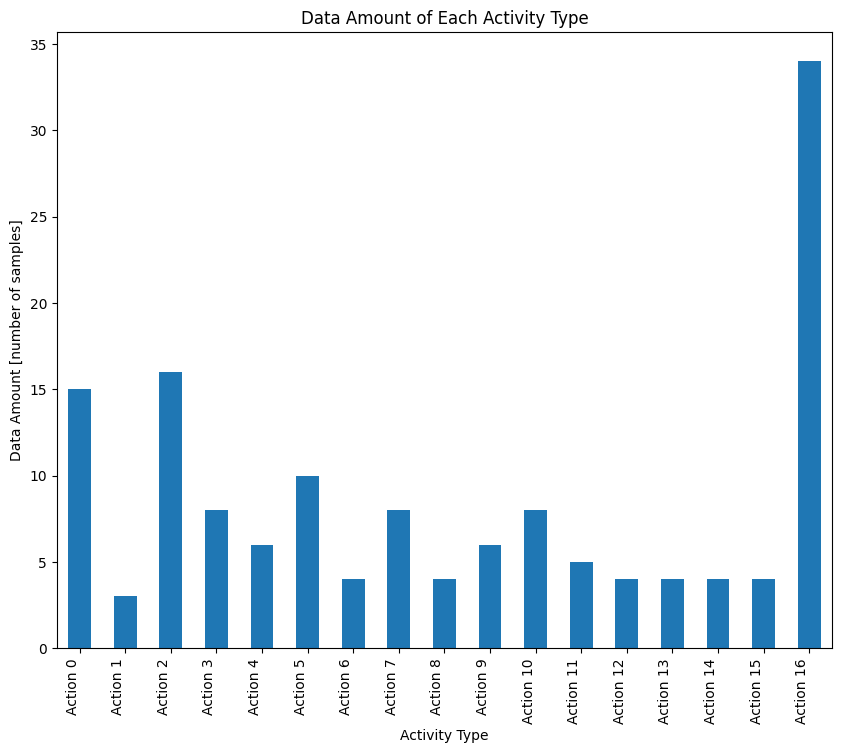

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Merge all users' `activityID` columns into one list
all_activity_ids = []

for ann_df in all_ann_data:
    all_activity_ids.extend(ann_df["activityID"])

# Convert all active tag IDs to Pandas Series for statistics
activity_series = pd.Series(all_activity_ids, name="activityID")

# Calculate the frequency of each active tag and generate a statistical table
activity_count = activity_series.value_counts().sort_index()
activity_count.index = [f"Action {i}" for i in activity_count.index]  # 为每个标签增加描述

# Draw a bar chart
plt.figure(figsize=(10, 8))
activity_count.plot(kind='bar')
plt.title('Data Amount of Each Activity Type')
plt.xlabel('Activity Type')
plt.ylabel('Data Amount [number of samples]')
plt.xticks(rotation=90, ha="right")
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Configuration and parameters
DATA_FOLDER = "/content/drive/MyDrive/Random/Hiroshima/ABC2025/Test"
TEST_IDS = ["T1N02", "T1F02"]  # Test data ID
FS = 33  # Sampling rate

# Action label encoding mapping
action_mapping = {
    "Explanation to patient": 0,
    "Confirm necessary items": 1,
    "Disinfect hands": 2,
    "Wearing gloves": 3,
    "Prepare the nutrition solution": 4,
    "Check the gastrostomy site": 5,
    "Open the gastrostomy cap": 6,
    "Inject lukewarm water": 7,
    "Connect the nutrition tube": 8,
    "Adjust the infusion rate": 9,
    "Removal of gloves": 10,
    "Prepare lukewarm water": 11,
    "Close the clamp": 12,
    "Disconnect the nutrition tube": 13,
    "Close the gastrostomy cap": 14,
    "Clean up used items": 15,
    "Others": 16
}

# Create a list to store all test user data
test_all_kp_data = []
test_all_ann_data = []

# Load and clean the data for each test user
for user_id in TEST_IDS:
    keypoint_csv = f"{DATA_FOLDER}/Body_KeyPoint_CSV/Front_{user_id}.csv"
    ann_csv = f"{DATA_FOLDER}/Annotation_CSV/Front_{user_id}.csv"

    # Load data
    kp_df = pd.read_csv(keypoint_csv).loc[:, ~pd.read_csv(keypoint_csv).columns.str.contains('^Unnamed')]
    ann_df = pd.read_csv(ann_csv).loc[:, ~pd.read_csv(ann_csv).columns.str.contains('^Unnamed')]

    # Clean up redundant columns
    kp_df = kp_df.loc[:, ~kp_df.columns.str.contains('Frame|conf|left_knee|right_knee|left_ankle|right_ankle', regex=True)]

    # Store the cleaned data in a list
    test_all_kp_data.append(kp_df)
    test_all_ann_data.append(ann_df)

print("Loaded and cleaned test data for all users.")

Loaded and cleaned test data for all users.


In [ ]:
SMOOTH_LEN = 3  # Smoothing length, in seconds

def smooth_kp(kp_col):
    zero_idx = np.flatnonzero(kp_col == 0)
    split_idx = np.split(zero_idx, np.flatnonzero(np.diff(zero_idx) > 1) + 1)
    for each_split_idx in split_idx:
        if len(each_split_idx) == 0 or each_split_idx[0] == 0 or each_split_idx[-1] == (len(kp_col) - 1) or len(each_split_idx) > SMOOTH_LEN * FS:
            continue
        xp = [each_split_idx[0] - 1, each_split_idx[-1] + 1]
        fp = kp_col[xp]
        interp_kp = np.interp(each_split_idx, xp, fp)
        kp_col[each_split_idx] = interp_kp
    return kp_col

# Smooth the data of each test user
for test_kp_df in test_all_kp_data:
    for i in range(len(test_kp_df.columns)):
        test_kp_df.iloc[:, i] = smooth_kp(np.array(test_kp_df.iloc[:, i]))

print("Smoothed all test keypoint data.")

Smoothed all test keypoint data.


In [ ]:
# Map activity names in test data to `activityID`
for test_ann_df in test_all_ann_data:
    test_ann_df["activityID"] = test_ann_df["annotation"].map(action_mapping)

print("Mapped test activity labels to activity IDs.")

Mapped test activity labels to activity IDs.


In [ ]:
test_all_features = []
test_all_labels = []

for test_kp_df, test_ann_df in zip(test_all_kp_data, test_all_ann_data):
    for i in range(len(test_ann_df)):
        # Extract the skeleton point data of the current active segment
        seg = test_kp_df.loc[int(test_ann_df['start_time'][i] * FS): int(test_ann_df['stop_time'][i] * FS)]
        seg_label = test_ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Split skeleton point data
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Extract features for each segment
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]

            # Add features and labels to the test data
            test_all_features.extend(feature_seg)
            test_all_labels.extend([seg_label] * len(ws_seg))

print("Extracted features and labels for all test users.")

Extracted features and labels for all test users.


In [ ]:
for test_kp_df in test_all_kp_data:
    # Calculate joint angles
    joint_angles = extract_joint_angles(np.array(test_kp_df))

    # Calculate speed characteristics
    velocity = extract_velocity(np.array(test_kp_df))

In [ ]:
test_all_features = []
test_all_labels = []

for test_kp_df, test_ann_df in zip(test_all_kp_data, test_all_ann_data):
    for i in range(len(test_ann_df)):
        # Extract the skeleton point data of the current active segment
        seg = test_kp_df.loc[int(test_ann_df['start_time'][i] * FS): int(test_ann_df['stop_time'][i] * FS)]
        seg_label = test_ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Calculate joint angles
            joint_angles = extract_joint_angles(np.array(seg))

            # Split skeleton point data and joint angle data
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Calculate the speed characteristics of each segment
            velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]

            # Extract skeleton features, angle features and speed features of each segment
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]
            feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in range(len(joint_angles_seg))]
            feature_velocity_seg = [extract_feature(velocity_seg[i], FS) for i in range(len(velocity_seg))]

            # Merge all features
            feature_seg_combined = [np.concatenate([feature_seg[j], feature_joint_angles_seg[j], feature_velocity_seg[j]]) for j in range(len(ws_seg))]

            # Add features and labels to the final test dataset
            test_all_features.extend(feature_seg_combined)
            test_all_labels.extend([seg_label] * len(ws_seg))

print("Extracted features and labels for all test users.")

Extracted features and labels for all test users.


In [ ]:
test_all_features = np.array(test_all_features)
test_all_labels = np.array(test_all_labels)

print("Total testing samples:", len(test_all_features))
print("Total testing labels:", len(test_all_labels))
print("Feature shape:", test_all_features.shape)

Total testing samples: 738
Total testing labels: 738
Feature shape: (738, 406)


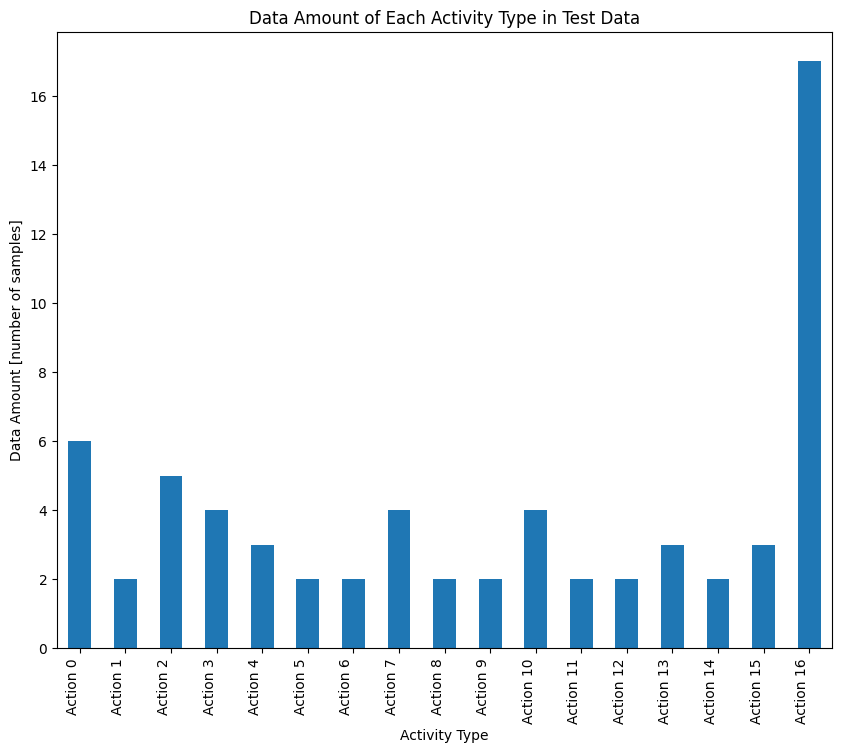

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine all test users' `activityID` columns into one list
test_all_activity_ids = []

for test_ann_df in test_all_ann_data:
    test_all_activity_ids.extend(test_ann_df["activityID"])

# Convert all active tag IDs to Pandas Series for statistics
test_activity_series = pd.Series(test_all_activity_ids, name="activityID")

# Calculate the frequency of each active tag and generate a statistical table
test_activity_count = test_activity_series.value_counts().sort_index()
test_activity_count.index = [f"Action {i}" for i in test_activity_count.index]  # 为每个标签增加描述

# Draw a bar chart
plt.figure(figsize=(10, 8))
test_activity_count.plot(kind='bar')
plt.title('Data Amount of Each Activity Type in Test Data')
plt.xlabel('Activity Type')
plt.ylabel('Data Amount [number of samples]')
plt.xticks(rotation=90, ha="right")
plt.show()

In [ ]:
print("Total samples of training data: {}".format(len(all_features)))
print("Total samples of testing data: {}".format(len(test_all_features)))
print("Total features: {}".format(np.shape(test_all_features)[1]))

Total samples of training data: 1462
Total samples of testing data: 738
Total features: 406


In [ ]:
def calculate_joint_distances(kp_data):
    # Get the coordinates of each key point
    left_wrist = kp_data[:, 10 * 2: 10 * 2 + 2]
    right_wrist = kp_data[:, 9 * 2: 9 * 2 + 2]
    left_elbow = kp_data[:, 8 * 2: 8 * 2 + 2]
    right_elbow = kp_data[:, 7 * 2: 7 * 2 + 2]
    left_shoulder = kp_data[:, 6 * 2: 6 * 2 + 2]
    right_shoulder = kp_data[:, 5 * 2: 5 * 2 + 2]
    left_hip = kp_data[:, 12 * 2: 12 * 2 + 2]
    right_hip = kp_data[:, 11 * 2: 11 * 2 + 2]

    # Calculate the distance between key points
    wrist_distance = np.linalg.norm(left_wrist - right_wrist, axis=1)
    left_wrist_elbow_distance = np.linalg.norm(left_wrist - left_elbow, axis=1)
    left_wrist_shoulder_distance = np.linalg.norm(left_wrist - left_shoulder, axis=1)
    left_wrist_hip_distance = np.linalg.norm(left_wrist - left_hip, axis=1)
    right_wrist_elbow_distance = np.linalg.norm(right_wrist - right_elbow, axis=1)
    right_wrist_shoulder_distance = np.linalg.norm(right_wrist - right_shoulder, axis=1)
    right_wrist_hip_distance = np.linalg.norm(right_wrist - right_hip, axis=1)

    # Merge distance features
    joint_distances = np.array([
        wrist_distance,
        left_wrist_elbow_distance,
        left_wrist_shoulder_distance,
        left_wrist_hip_distance,
        right_wrist_elbow_distance,
        right_wrist_shoulder_distance,
        right_wrist_hip_distance
    ]).T

    return joint_distances

In [ ]:
all_features = []
all_labels = []

for kp_df, ann_df in zip(all_kp_data, all_ann_data):
    for i in range(len(ann_df)):
        # Extract the skeleton point data of the current active segment
        seg = kp_df.loc[int(ann_df['start_time'][i] * FS): int(ann_df['stop_time'][i] * FS)]
        seg_label = ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Calculate joint angle and joint distance features
            joint_angles = extract_joint_angles(np.array(seg))
            joint_distances = calculate_joint_distances(np.array(seg))

            # Segment skeleton data, joint angle data, and joint distance data
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_distances_seg = segment(joint_distances, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Calculate the velocity characteristics of each segment
            velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]

            # Extract skeleton features, joint angle features, velocity features, and joint distance features
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]
            feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in range(len(joint_angles_seg))]
            feature_velocity_seg = [extract_feature(velocity_seg[i], FS) for i in range(len(velocity_seg))]
            feature_joint_distances_seg = [extract_feature(joint_distances_seg[i], FS) for i in range(len(joint_distances_seg))]

            # Ensure all features have the same length
            min_len = min(len(feature_seg), len(feature_joint_angles_seg), len(feature_velocity_seg), len(feature_joint_distances_seg))

            # Combine all features into a single feature vector
            feature_seg_combined = [
                np.concatenate([feature_seg[j], feature_joint_angles_seg[j], feature_velocity_seg[j], feature_joint_distances_seg[j]])
                for j in range(min_len)
            ]

            # Add features and labels to the final training dataset
            all_features.extend(feature_seg_combined)
            all_labels.extend([seg_label] * min_len)

print("Extracted features and labels for all users.")

Extracted features and labels for all users.


In [ ]:
# Processing test data with additional wrist-related joint distances
test_all_features = []
test_all_labels = []

for test_kp_df, test_ann_df in zip(test_all_kp_data, test_all_ann_data):
    for i in range(len(test_ann_df)):
        # Get the skeleton data of the current activity segment
        seg = test_kp_df.loc[int(test_ann_df['start_time'][i] * FS): int(test_ann_df['stop_time'][i] * FS)]
        seg_label = test_ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Calculate joint angles and joint distances
            joint_angles = extract_joint_angles(np.array(seg))
            joint_distances = calculate_joint_distances(np.array(seg))

            # Segment skeleton data, joint angles, and joint distances
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_distances_seg = segment(joint_distances, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Calculate velocity features after defining ws_seg
            velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]

            # Extract skeleton features, joint angle features, velocity features, and joint distance features
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]
            feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in range(len(joint_angles_seg))]
            feature_velocity_seg = [extract_feature(velocity_seg[i], FS) for i in range(len(velocity_seg))]
            feature_joint_distances_seg = [extract_feature(joint_distances_seg[i], FS) for i in range(len(joint_distances_seg))]

            # Ensure all feature lengths are consistent
            min_len = min(len(feature_seg), len(feature_joint_angles_seg), len(feature_velocity_seg), len(feature_joint_distances_seg))

            # Combine all features into a single feature vector
            feature_seg_combined = [
                np.concatenate([feature_seg[j], feature_joint_angles_seg[j], feature_velocity_seg[j], feature_joint_distances_seg[j]])
                for j in range(min_len)
            ]

            # Add features and labels to the final test dataset
            test_all_features.extend(feature_seg_combined)
            test_all_labels.extend([seg_label] * min_len)

print("Extracted features and labels for all test users.")

Extracted features and labels for all test users.


In [ ]:
print("Total samples of training data: {}".format(len(all_features)))
print("Total samples of testing data: {}".format(len(test_all_features)))
print("Total features: {}".format(np.shape(test_all_features)[1]))

Total samples of training data: 1462
Total samples of testing data: 738
Total features: 455


In [ ]:
def calculate_hip_shoulder_distance(kp_data, steps=2):
    # Extract the key point coordinates of both hips
    left_hip = kp_data[:, 12 * steps : 12 * steps + 2]
    right_hip = kp_data[:, 11 * steps : 11 * steps + 2]

    # Calculate the distance between the two hips
    hip_distance = np.linalg.norm(left_hip - right_hip, axis=1)

    return hip_distance

def calculate_shoulder_distance(kp_data, steps=2):
    # Extract the key point coordinates of the shoulders
    left_shoulder = kp_data[:, 6 * steps : 6 * steps + 2]
    right_shoulder = kp_data[:, 5 * steps : 5 * steps + 2]

    # Calculate the distance between shoulders
    shoulder_distance = np.linalg.norm(left_shoulder - right_shoulder, axis=1)

    return shoulder_distance

def extract_acceleration(kp_data):
    # Calculate speed (difference of speed)
    velocity = np.diff(kp_data, axis=0)

    # Calculate acceleration (based on velocity)
    acceleration = np.diff(velocity, axis=0)

    # Returns the modulus of the acceleration feature
    acceleration_magnitude = np.linalg.norm(acceleration, axis=1)
    return acceleration_magnitude

In [ ]:
all_features = []
all_labels = []

for kp_df, ann_df in zip(all_kp_data, all_ann_data):
    for i in range(len(ann_df)):
        # Extract the skeleton data of the current active segment
        seg = kp_df.loc[int(ann_df['start_time'][i] * FS): int(ann_df['stop_time'][i] * FS)]
        seg_label = ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Calculate joint angle and distance features
            joint_angles = extract_joint_angles(np.array(seg))
            joint_distances = calculate_joint_distances(np.array(seg))

            # Calculate new features
            hip_distance = calculate_hip_shoulder_distance(np.array(seg))
            shoulder_distance = calculate_shoulder_distance(np.array(seg))

            # Segment each feature
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_distances_seg = segment(joint_distances, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            hip_distance_seg = segment(hip_distance, max_time=len(hip_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            shoulder_distance_seg = segment(shoulder_distance, max_time=len(shoulder_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Calculate the speed characteristics of each segment
            velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]
            acceleration_seg = [extract_acceleration(ws_seg[i]) for i in range(len(ws_seg))]

            # Extract features from each segment
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]
            feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in range(len(joint_angles_seg))]
            feature_velocity_seg = [extract_feature(velocity_seg[i], FS) for i in range(len(velocity_seg))]
            feature_joint_distances_seg = [extract_feature(joint_distances_seg[i], FS) for i in range(len(joint_distances_seg))]
            feature_hip_distance_seg = [extract_feature(hip_distance_seg[i], FS) for i in range(len(hip_distance_seg))]
            feature_shoulder_distance_seg = [extract_feature(shoulder_distance_seg[i], FS) for i in range(len(shoulder_distance_seg))]
            feature_acceleration_seg = [extract_feature(acceleration_seg[i], FS) for i in range(len(acceleration_seg))]

            # Make sure all features have the same length
            min_len = min(
                len(feature_seg),
                len(feature_joint_angles_seg),
                len(feature_velocity_seg),
                len(feature_joint_distances_seg),
                len(feature_hip_distance_seg),
                len(feature_shoulder_distance_seg),
                len(feature_acceleration_seg),
            )

            # Merge all features into a single feature vector
            feature_seg_combined = [
                np.concatenate([
                    feature_seg[j],
                    feature_joint_angles_seg[j],
                    feature_velocity_seg[j],
                    feature_joint_distances_seg[j],
                    feature_hip_distance_seg[j],
                    feature_shoulder_distance_seg[j],
                    feature_acceleration_seg[j],
                ])
                for j in range(min_len)
            ]

            # Add features and labels to the final dataset
            all_features.extend(feature_seg_combined)
            all_labels.extend([seg_label] * min_len)

print("Extracted features and labels for all users.")

Extracted features and labels for all users.


In [ ]:
test_all_features = []
test_all_labels = []

for test_kp_df, test_ann_df in zip(test_all_kp_data, test_all_ann_data):
    for i in range(len(test_ann_df)):
        # Extract the skeleton data of the current active segment
        seg = test_kp_df.loc[int(test_ann_df['start_time'][i] * FS):
            int(test_ann_df['stop_time'][i] * FS)]
        seg_label = test_ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Calculate joint angle and distance features
            joint_angles = extract_joint_angles(np.array(seg))
            joint_distances = calculate_joint_distances(np.array(seg))

            # Calculate new features
            hip_distance = calculate_hip_shoulder_distance(np.array(seg))
            shoulder_distance = calculate_shoulder_distance(np.array(seg))

            # Segment each feature
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_distances_seg = segment(joint_distances, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            hip_distance_seg = segment(hip_distance, max_time=len(hip_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            shoulder_distance_seg = segment(shoulder_distance, max_time=len(shoulder_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Calculate the speed characteristics of each segment
            velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]
            acceleration_seg = [extract_acceleration(ws_seg[i]) for i in range(len(ws_seg))]

            # Extract features from each segment
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]
            feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in range(len(joint_angles_seg))]
            feature_velocity_seg = [extract_feature(velocity_seg[i], FS) for i in range(len(velocity_seg))]
            feature_joint_distances_seg = [extract_feature(joint_distances_seg[i], FS) for i in range(len(joint_distances_seg))]
            feature_hip_distance_seg = [extract_feature(hip_distance_seg[i], FS) for i in range(len(hip_distance_seg))]
            feature_shoulder_distance_seg = [extract_feature(shoulder_distance_seg[i], FS) for i in range(len(shoulder_distance_seg))]
            feature_acceleration_seg = [extract_feature(acceleration_seg[i], FS) for i in range(len(acceleration_seg))]

            # Make sure all features have the same length
            min_len = min(
                len(feature_seg),
                len(feature_joint_angles_seg),
                len(feature_velocity_seg),
                len(feature_joint_distances_seg),
                len(feature_hip_distance_seg),
                len(feature_shoulder_distance_seg),
                len(feature_acceleration_seg),
            )

            # Merge all features into a single feature vector
            feature_seg_combined = [
                np.concatenate([
                    feature_seg[j],
                    feature_joint_angles_seg[j],
                    feature_velocity_seg[j],
                    feature_joint_distances_seg[j],
                    feature_hip_distance_seg[j],
                    feature_shoulder_distance_seg[j],
                    feature_acceleration_seg[j],
                ])
                for j in range(min_len)
            ]

            # Add features and labels to the final dataset
            test_all_features.extend(feature_seg_combined)
            test_all_labels.extend([seg_label] * min_len)

print("Extracted features and labels for all users.")

Extracted features and labels for all users.


In [ ]:
print("Total samples of training data: {}".format(len(all_features)))
print("Total samples of testing data: {}".format(len(test_all_features)))
print("Total features: {}".format(np.shape(all_features)[1]))

Total samples of training data: 1462
Total samples of testing data: 738
Total features: 476


In [ ]:
def extract_jerk(kp_data):
    """
    Calculate the Jerk magnitude for each frame.
    Args:
        kp_data: numpy array, keypoint data of shape (n_frames, n_features).
    Returns:
        jerk_magnitude: numpy array of jerk magnitudes for each frame (n_frames - 3,).
    """

    # Calculate velocity
    velocity = np.diff(kp_data, axis=0)

    # Calculate acceleration
    acceleration = np.diff(velocity, axis=0)

    # Calculate Jerk (change of acceleration)
    jerk = np.diff(acceleration, axis=0)

    # Calculate the magnitude of Jerk
    jerk_magnitude = np.linalg.norm(jerk, axis=1)

    # Replace NaN values with 0
    jerk_magnitude = np.nan_to_num(jerk_magnitude, nan=0.0)

    return jerk_magnitude

In [ ]:
def calculate_jerk(kp_data, frame_rate=33):
    """
    Calculate the Jerk features (rate of change of acceleration) from skeleton data.

    Args:
        kp_data: numpy array of 2D or 3D coordinates (n_frames x n_features).
        frame_rate: Frame rate (default is 33 FPS).

    Returns:
        jerk: Jerk feature array (n_frames-3 x n_features).
    """
    time_interval = 1.0 / frame_rate  # Frame-to-frame time interval
    velocity = np.diff(kp_data, axis=0) / time_interval
    acceleration = np.diff(velocity, axis=0) / time_interval
    jerk = np.diff(acceleration, axis=0) / time_interval  # Rate of change of acceleration
    return jerk

In [ ]:
all_features = []
all_labels = []

for kp_df, ann_df in zip(all_kp_data, all_ann_data):
    for i in range(len(ann_df)):
        # Extract the skeleton data of the current active segment
        seg = kp_df.loc[int(ann_df['start_time'][i] * FS): int(ann_df['stop_time'][i] * FS)]
        seg_label = ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Calculate joint angle and distance features
            joint_angles = extract_joint_angles(np.array(seg))
            joint_distances = calculate_joint_distances(np.array(seg))

            # Calculate new features
            hip_distance = calculate_hip_shoulder_distance(np.array(seg))
            shoulder_distance = calculate_shoulder_distance(np.array(seg))

            # Calculate jerk features
            jerk_features = calculate_jerk(np.array(seg), frame_rate=FS)

            # Segment each feature
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_distances_seg = segment(joint_distances, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            hip_distance_seg = segment(hip_distance, max_time=len(hip_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            shoulder_distance_seg = segment(shoulder_distance, max_time=len(shoulder_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Calculate the speed characteristics of each segment
            velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]
            acceleration_seg = [extract_acceleration(ws_seg[i]) for i in range(len(ws_seg))]
            jerk_seg = [extract_jerk(ws_seg[i]) for i in range(len(ws_seg))]

            # Extract features from each segment
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]
            feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in range(len(joint_angles_seg))]
            feature_velocity_seg = [extract_feature(velocity_seg[i], FS) for i in range(len(velocity_seg))]
            feature_joint_distances_seg = [extract_feature(joint_distances_seg[i], FS) for i in range(len(joint_distances_seg))]
            feature_hip_distance_seg = [extract_feature(hip_distance_seg[i], FS) for i in range(len(hip_distance_seg))]
            feature_shoulder_distance_seg = [extract_feature(shoulder_distance_seg[i], FS) for i in range(len(shoulder_distance_seg))]
            feature_acceleration_seg = [extract_feature(acceleration_seg[i], FS) for i in range(len(acceleration_seg))]
            feature_jerk_seg = [extract_feature(jerk_seg[i], FS) for i in range(len(jerk_seg))]

            # Make sure all features have the same length
            min_len = min(
                len(feature_seg),
                len(feature_joint_angles_seg),
                len(feature_velocity_seg),
                len(feature_joint_distances_seg),
                len(feature_hip_distance_seg),
                len(feature_shoulder_distance_seg),
                len(feature_acceleration_seg),
                len(feature_jerk_seg),
            )

            # Merge all features into a single feature vector
            feature_seg_combined = [
                np.concatenate([
                    feature_seg[j],
                    feature_joint_angles_seg[j],
                    feature_velocity_seg[j],
                    feature_joint_distances_seg[j],
                    feature_hip_distance_seg[j],
                    feature_shoulder_distance_seg[j],
                    feature_acceleration_seg[j],
                    feature_jerk_seg[j],
                ])
                for j in range(min_len)
            ]

            # Add features and labels to the final dataset
            all_features.extend(feature_seg_combined)
            all_labels.extend([seg_label] * min_len)

print("Extracted features and labels for all users.")

Extracted features and labels for all users.


In [ ]:
test_all_features = []
test_all_labels = []

for test_kp_df, test_ann_df in zip(test_all_kp_data, test_all_ann_data):
    for i in range(len(test_ann_df)):
        # Extract the skeleton data of the current active segment
        seg = test_kp_df.loc[int(test_ann_df['start_time'][i] * FS): int(test_ann_df['stop_time'][i] * FS)]
        seg_label = test_ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Calculate joint angle and distance features
            joint_angles = extract_joint_angles(np.array(seg))
            joint_distances = calculate_joint_distances(np.array(seg))

            # Calculate new features
            hip_distance = calculate_hip_shoulder_distance(np.array(seg))
            shoulder_distance = calculate_shoulder_distance(np.array(seg))

            # Calculate jerk features
            jerk_features = calculate_jerk(np.array(seg), frame_rate=FS)

            # Segment each feature
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_distances_seg = segment(joint_distances, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            hip_distance_seg = segment(hip_distance, max_time=len(hip_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            shoulder_distance_seg = segment(shoulder_distance, max_time=len(shoulder_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Calculate the speed characteristics of each segment
            velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]
            acceleration_seg = [extract_acceleration(ws_seg[i]) for i in range(len(ws_seg))]
            jerk_seg = [extract_jerk(ws_seg[i]) for i in range(len(ws_seg))]

            # Extract features from each segment
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]
            feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in range(len(joint_angles_seg))]
            feature_velocity_seg = [extract_feature(velocity_seg[i], FS) for i in range(len(velocity_seg))]
            feature_joint_distances_seg = [extract_feature(joint_distances_seg[i], FS) for i in range(len(joint_distances_seg))]
            feature_hip_distance_seg = [extract_feature(hip_distance_seg[i], FS) for i in range(len(hip_distance_seg))]
            feature_shoulder_distance_seg = [extract_feature(shoulder_distance_seg[i], FS) for i in range(len(shoulder_distance_seg))]
            feature_acceleration_seg = [extract_feature(acceleration_seg[i], FS) for i in range(len(acceleration_seg))]
            feature_jerk_seg = [extract_feature(jerk_seg[i], FS) for i in range(len(jerk_seg))]

            # Make sure all features have the same length
            min_len = min(
                len(feature_seg),
                len(feature_joint_angles_seg),
                len(feature_velocity_seg),
                len(feature_joint_distances_seg),
                len(feature_hip_distance_seg),
                len(feature_shoulder_distance_seg),
                len(feature_acceleration_seg),
                len(feature_jerk_seg),
            )

            # Merge all features into a single feature vector
            feature_seg_combined = [
                np.concatenate([
                    feature_seg[j],
                    feature_joint_angles_seg[j],
                    feature_velocity_seg[j],
                    feature_joint_distances_seg[j],
                    feature_hip_distance_seg[j],
                    feature_shoulder_distance_seg[j],
                    feature_acceleration_seg[j],
                    feature_jerk_seg[j],
                ])
                for j in range(min_len)
            ]

            # Add features and labels to the final dataset
            test_all_features.extend(feature_seg_combined)
            test_all_labels.extend([seg_label] * min_len)

print("Extracted features and labels for all test users.")

Extracted features and labels for all test users.


In [ ]:
all_features = np.array(all_features)
test_all_features = np.array(test_all_features)

print("Total training samples:", len(all_features))
print("Total testing samples:", len(test_all_features))
print("Feature shape (train):", all_features.shape)
print("Feature shape (test):", test_all_features.shape)

Total training samples: 1462
Total testing samples: 738
Feature shape (train): (1462, 483)
Feature shape (test): (738, 483)


In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(k_neighbors=2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(all_features, all_labels)

In [ ]:
'''

# Define the random forest model
model_rf = RandomForestClassifier()

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(model_rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Output the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

'''

'\n\n# Define the random forest model\nmodel_rf = RandomForestClassifier()\n\n# Define parameter grid for Random Forest\nparam_grid = {\n    \'n_estimators\': [100, 300, 500],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'sqrt\', \'log2\'],\n    \'bootstrap\': [True, False]\n}\n\n# Use GridSearchCV to search for the best parameters\ngrid_search = GridSearchCV(model_rf, param_grid, cv=5, scoring=\'accuracy\', n_jobs=-1)\ngrid_search.fit(X_train_resampled, y_train_resampled)\n\n# Output the best parameters and the best score\nprint("Best parameters found: ", grid_search.best_params_)\nprint("Best cross-validation score: ", grid_search.best_score_)\n\n'

In [ ]:
'''

# Create a model using the best parameters
model_rf = RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    max_features=grid_search.best_params_['max_features'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    bootstrap=grid_search.best_params_['bootstrap'],
    n_jobs=-1
)

# Model training
model_rf.fit(X_train_resampled, y_train_resampled)

'''

"\n\n# Create a model using the best parameters\nmodel_rf = RandomForestClassifier(\n    n_estimators=grid_search.best_params_['n_estimators'],\n    max_depth=grid_search.best_params_['max_depth'],\n    max_features=grid_search.best_params_['max_features'],\n    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],\n    min_samples_split=grid_search.best_params_['min_samples_split'],\n    bootstrap=grid_search.best_params_['bootstrap'],\n    n_jobs=-1\n)\n\n# Model training\nmodel_rf.fit(X_train_resampled, y_train_resampled)\n\n"

In [ ]:
'''

# Get the total number of categories
TOTAL_CLASSESS = len(action_mapping)

'''

'\n\n# Get the total number of categories\nTOTAL_CLASSESS = len(action_mapping)\n\n'

In [ ]:
'''

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Use the model to predict the labels of the test data
y_predict = model_rf.predict(test_all_features)

# Output classification report
print(classification_report(test_all_labels, y_predict))

# Calculate the confusion matrix
cm = confusion_matrix(test_all_labels, y_predict, labels=np.unique(test_all_labels))

# Normalize the confusion matrix
cm_norm = cm / np.sum(cm, axis=1, keepdims=True)

# Draw a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 9))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', annot_kws={"fontsize":6}, yticklabels=np.arange(TOTAL_CLASSESS), xticklabels=np.arange(TOTAL_CLASSESS))
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

'''

'\n\nfrom sklearn.metrics import classification_report, confusion_matrix\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Use the model to predict the labels of the test data\ny_predict = model_rf.predict(test_all_features)\n\n# Output classification report\nprint(classification_report(test_all_labels, y_predict))\n\n# Calculate the confusion matrix\ncm = confusion_matrix(test_all_labels, y_predict, labels=np.unique(test_all_labels))\n\n# Normalize the confusion matrix\ncm_norm = cm / np.sum(cm, axis=1, keepdims=True)\n\n# Draw a heatmap of the normalized confusion matrix\nplt.figure(figsize=(10, 9))\nsns.heatmap(cm_norm, annot=True, fmt=\'.2f\', cmap=\'Blues\', annot_kws={"fontsize":6}, yticklabels=np.arange(TOTAL_CLASSESS), xticklabels=np.arange(TOTAL_CLASSESS))\nplt.title("Normalized Confusion Matrix")\nplt.xlabel("Predicted Label")\nplt.ylabel("True Label")\nplt.show()\n\n'

In [ ]:
'''

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use the model to predict the labels of the test data
y_predict = model_rf.predict(test_all_features)

# Output classification report
print(classification_report(test_all_labels, y_predict))

# Calculate the confusion matrix
cm = confusion_matrix(test_all_labels, y_predict, labels=np.unique(test_all_labels))

# Draw a heatmap of the confusion matrix (without normalization)
plt.figure(figsize=(10, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize":6}, yticklabels=np.arange(TOTAL_CLASSESS), xticklabels=np.arange(TOTAL_CLASSESS))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

'''

'\n\nfrom sklearn.metrics import classification_report, confusion_matrix\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport numpy as np\n\n# Use the model to predict the labels of the test data\ny_predict = model_rf.predict(test_all_features)\n\n# Output classification report\nprint(classification_report(test_all_labels, y_predict))\n\n# Calculate the confusion matrix\ncm = confusion_matrix(test_all_labels, y_predict, labels=np.unique(test_all_labels))\n\n# Draw a heatmap of the confusion matrix (without normalization)\nplt.figure(figsize=(10, 9))\nsns.heatmap(cm, annot=True, fmt=\'d\', cmap=\'Blues\', annot_kws={"fontsize":6}, yticklabels=np.arange(TOTAL_CLASSESS), xticklabels=np.arange(TOTAL_CLASSESS))\nplt.title("Confusion Matrix")\nplt.xlabel("Predicted Label")\nplt.ylabel("True Label")\nplt.show()\n\n'

In [ ]:
'''

import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Store results for each test user
test_results = {}

# Iterate through each test user and calculate accuracy and F1-score
for test_user_id, test_kp_df, test_ann_df in zip(TEST_IDS, test_all_kp_data, test_all_ann_data):
    test_features = []
    test_labels = []

    for i in range(len(test_ann_df)):
        # Extract the skeleton point data for the current activity segment
        seg = test_kp_df.loc[int(test_ann_df['start_time'][i] * FS): int(test_ann_df['stop_time'][i] * FS)]
        seg_label = test_ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Calculate joint angles and distance features
            joint_angles = extract_joint_angles(np.array(seg))
            joint_distances = calculate_joint_distances(np.array(seg))

            # Calculate new features
            hip_distance = calculate_hip_shoulder_distance(np.array(seg))  # Returns distance between hips
            shoulder_distance = calculate_shoulder_distance(np.array(seg))  # Returns distance between shoulders

            # Calculate jerk features
            jerk_features = calculate_jerk(np.array(seg), frame_rate=FS)

            # Segment features
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_distances_seg = segment(joint_distances, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            hip_distance_seg = segment(hip_distance, max_time=len(hip_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            shoulder_distance_seg = segment(shoulder_distance, max_time=len(shoulder_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Calculate velocity features for each segment
            velocity_seg = [extract_velocity(ws_seg[j]) for j in range(len(ws_seg))]
            acceleration_seg = [extract_acceleration(ws_seg[j]) for j in range(len(ws_seg))]
            jerk_seg = [extract_jerk(ws_seg[i]) for i in range(len(ws_seg))]

            # Extract features from each segment
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]
            feature_joint_angles_seg = [extract_feature(joint_angles_seg[j], FS) for j in range(len(joint_angles_seg))]
            feature_velocity_seg = [extract_feature(velocity_seg[j], FS) for j in range(len(velocity_seg))]
            feature_joint_distances_seg = [extract_feature(joint_distances_seg[j], FS) for j in range(len(joint_distances_seg))]
            feature_hip_distance_seg = [extract_feature(hip_distance_seg[j], FS) for j in range(len(hip_distance_seg))]
            feature_shoulder_distance_seg = [extract_feature(shoulder_distance_seg[j], FS) for j in range(len(shoulder_distance_seg))]
            feature_acceleration_seg = [extract_feature(acceleration_seg[j], FS) for j in range(len(acceleration_seg))]
            feature_jerk_seg = [extract_feature(jerk_seg[i], FS) for i in range(len(jerk_seg))]

            # Ensure all features have the same length
            min_len = min(
                len(feature_seg),
                len(feature_joint_angles_seg),
                len(feature_velocity_seg),
                len(feature_joint_distances_seg),
                len(feature_hip_distance_seg),
                len(feature_shoulder_distance_seg),
                len(feature_acceleration_seg),
                len(feature_jerk_seg),
            )

            # Combine all features into a single feature vector
            feature_seg_combined = [
                np.concatenate([
                    feature_seg[j],
                    feature_joint_angles_seg[j],
                    feature_velocity_seg[j],
                    feature_joint_distances_seg[j],
                    feature_hip_distance_seg[j],
                    feature_shoulder_distance_seg[j],
                    feature_acceleration_seg[j],
                    feature_jerk_seg[j],
                ])
                for j in range(min_len)
            ]

            # Add features and labels to the final dataset
            test_features.extend(feature_seg_combined)
            test_labels.extend([seg_label] * min_len)

    # Convert to arrays for prediction
    test_features = np.array(test_features)
    test_labels = np.array(test_labels)

    # Predict and evaluate for the current user
    y_pred = model_rf.predict(test_features)
    acc = accuracy_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred, average="weighted")

    # Store results
    test_results[test_user_id] = {"Accuracy": acc, "F1-score": f1}

# Create and format results table
results_df = pd.DataFrame(test_results).T
results_df.index.name = 'File'
results_df.loc['TOTAL'] = results_df.mean()
results_df = results_df.round(2)

# Display results with bold headers and TOTAL row
print(f"\033[1m{'File':<8}   {'Accuracy':<10}   {'F1-score':<10}\033[0m")
print(" ")
for idx, row in results_df.iterrows():
    if idx == 'TOTAL':
        print(" ")
        print(f"\033[1m{idx:<8}   {row['Accuracy']:<10.2f}   {row['F1-score']:<10.2f}\033[0m")
    else:
        print(f"{idx:<8}   {row['Accuracy']:<10.2f}   {row['F1-score']:<10.2f}")
print(" ")

'''

'\n\nimport pandas as pd\nfrom sklearn.metrics import accuracy_score, f1_score\nimport numpy as np\n\n# Store results for each test user\ntest_results = {}\n\n# Iterate through each test user and calculate accuracy and F1-score\nfor test_user_id, test_kp_df, test_ann_df in zip(TEST_IDS, test_all_kp_data, test_all_ann_data):\n    test_features = []\n    test_labels = []\n\n    for i in range(len(test_ann_df)):\n        # Extract the skeleton point data for the current activity segment\n        seg = test_kp_df.loc[int(test_ann_df[\'start_time\'][i] * FS): int(test_ann_df[\'stop_time\'][i] * FS)]\n        seg_label = test_ann_df["activityID"].iloc[i]\n\n        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):\n            # Calculate joint angles and distance features\n            joint_angles = extract_joint_angles(np.array(seg))\n            joint_distances = calculate_joint_distances(np.array(seg))\n\n            # Calculate new features\n            hip_distance = calculate_hip_sh

In [ ]:
'''

import numpy as np
import matplotlib.pyplot as plt

# 假设模型已经训练完成，获取特征重要性
feature_importances = model_rf.feature_importances_

# 按特征类别分组
num_feature_seg_features = len(feature_seg[0]) * min_len  # 基础特征
num_joint_angle_features = len(feature_joint_angles_seg[0]) * min_len
num_joint_distance_features = len(feature_joint_distances_seg[0]) * min_len
num_hip_distance_features = len(feature_hip_distance_seg[0]) * min_len
num_shoulder_distance_features = len(feature_shoulder_distance_seg[0]) * min_len
num_velocity_features = len(feature_velocity_seg[0]) * min_len
num_acceleration_features = len(feature_acceleration_seg[0]) * min_len
num_jerk_features = len(feature_jerk_seg[0]) * min_len

# 按类别划分特征重要性
feature_seg_importance = np.sum(feature_importances[:num_feature_seg_features])
joint_angle_importance = np.sum(feature_importances[num_feature_seg_features:num_feature_seg_features + num_joint_angle_features])
joint_distance_importance = np.sum(feature_importances[num_feature_seg_features + num_joint_angle_features:num_feature_seg_features + num_joint_angle_features + num_joint_distance_features])
hip_distance_importance = np.sum(feature_importances[num_feature_seg_features + num_joint_angle_features + num_joint_distance_features:num_feature_seg_features + num_joint_angle_features + num_joint_distance_features + num_hip_distance_features])
shoulder_distance_importance = np.sum(feature_importances[num_feature_seg_features + num_joint_angle_features + num_joint_distance_features + num_hip_distance_features:num_feature_seg_features + num_joint_angle_features + num_joint_distance_features + num_hip_distance_features + num_shoulder_distance_features])
velocity_importance = np.sum(feature_importances[num_feature_seg_features + num_joint_angle_features + num_joint_distance_features + num_hip_distance_features + num_shoulder_distance_features:num_feature_seg_features + num_joint_angle_features + num_joint_distance_features + num_hip_distance_features + num_shoulder_distance_features + num_velocity_features])
acceleration_importance = np.sum(feature_importances[num_feature_seg_features + num_joint_angle_features + num_joint_distance_features + num_hip_distance_features + num_shoulder_distance_features + num_velocity_features:num_feature_seg_features + num_joint_angle_features + num_joint_distance_features + num_hip_distance_features + num_shoulder_distance_features + num_velocity_features + num_acceleration_features])
jerk_importance = np.sum(feature_importances[num_feature_seg_features + num_joint_angle_features + num_joint_distance_features + num_hip_distance_features + num_shoulder_distance_features + num_velocity_features + num_acceleration_features:])

# 将各类别重要性汇总
feature_group_importance = {
    "Base Features": feature_seg_importance,
    "Joint Angles": joint_angle_importance,
    "Joint Distances": joint_distance_importance,
    "Hip Distances": hip_distance_importance,
    "Shoulder Distances": shoulder_distance_importance,
    "Velocity": velocity_importance,
    "Acceleration": acceleration_importance,
    "Jerk": jerk_importance
}

# 输出各类别的重要性
print("Feature Importance by Group:")
for feature_group, importance in feature_group_importance.items():
    print(f"{feature_group}: {importance:.4f}")

# 可视化
plt.figure(figsize=(10, 6))
plt.bar(feature_group_importance.keys(), feature_group_importance.values(), color='skyblue')
plt.title("Feature Importance by Group")
plt.xlabel("Feature Group")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

'''

'\n\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# 假设模型已经训练完成，获取特征重要性\nfeature_importances = model_rf.feature_importances_\n\n# 按特征类别分组\nnum_feature_seg_features = len(feature_seg[0]) * min_len  # 基础特征\nnum_joint_angle_features = len(feature_joint_angles_seg[0]) * min_len\nnum_joint_distance_features = len(feature_joint_distances_seg[0]) * min_len\nnum_hip_distance_features = len(feature_hip_distance_seg[0]) * min_len\nnum_shoulder_distance_features = len(feature_shoulder_distance_seg[0]) * min_len\nnum_velocity_features = len(feature_velocity_seg[0]) * min_len\nnum_acceleration_features = len(feature_acceleration_seg[0]) * min_len\nnum_jerk_features = len(feature_jerk_seg[0]) * min_len\n\n# 按类别划分特征重要性\nfeature_seg_importance = np.sum(feature_importances[:num_feature_seg_features])\njoint_angle_importance = np.sum(feature_importances[num_feature_seg_features:num_feature_seg_features + num_joint_angle_features])\njoint_distance_importance = np.sum(feature_importances[num_feat

In [ ]:
def calculate_center_of_mass(kp_data, min_len):
    """
    计算重心轨迹特征。
    """
    # 提取肩部和臀部关键点，计算重心
    left_shoulder = kp_data[:, 6 * 2:6 * 2 + 2]
    right_shoulder = kp_data[:, 5 * 2:5 * 2 + 2]
    left_hip = kp_data[:, 12 * 2:12 * 2 + 2]
    right_hip = kp_data[:, 11 * 2:11 * 2 + 2]

    # 重心计算
    center_of_mass = (left_shoulder + right_shoulder + left_hip + right_hip) / 4

    # 平滑并计算轨迹变化
    trajectory_change = np.linalg.norm(np.diff(center_of_mass, axis=0), axis=1)
    trajectory_features = np.mean(trajectory_change[:min_len])

    return trajectory_features

def calculate_hand_distance(kp_data, min_len):
    """
    计算双手距离特征。
    """
    left_wrist = kp_data[:, 10 * 2:10 * 2 + 2]
    right_wrist = kp_data[:, 9 * 2:9 * 2 + 2]

    # 距离变化
    hand_distance = np.linalg.norm(left_wrist - right_wrist, axis=1)
    return np.mean(hand_distance[:min_len])

def calculate_head_orientation(kp_data, min_len):
    """
    计算头部姿态（倾斜角度）。
    """
    nose = kp_data[:, 0 * 2:0 * 2 + 2]
    left_ear = kp_data[:, 4 * 2:4 * 2 + 2]
    right_ear = kp_data[:, 3 * 2:3 * 2 + 2]

    # 简单计算头部倾斜角度
    head_tilt = np.arctan2(left_ear[:, 1] - right_ear[:, 1], left_ear[:, 0] - right_ear[:, 0])
    return np.mean(head_tilt[:min_len])

In [ ]:
all_features = []
all_labels = []

for kp_df, ann_df in zip(all_kp_data, all_ann_data):
    for i in range(len(ann_df)):
        # Extract the skeleton data of the current active segment
        seg = kp_df.loc[int(ann_df['start_time'][i] * FS): int(ann_df['stop_time'][i] * FS)]
        seg_label = ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Calculate joint angle and distance features
            joint_angles = extract_joint_angles(np.array(seg))
            joint_distances = calculate_joint_distances(np.array(seg))

            # Calculate new features
            hip_distance = calculate_hip_shoulder_distance(np.array(seg))
            shoulder_distance = calculate_shoulder_distance(np.array(seg))
            jerk_features = calculate_jerk(np.array(seg), frame_rate=FS)

            # Calculate newly added features
            min_len = min(len(seg), len(joint_angles), len(joint_distances))  # Ensure matching lengths
            center_of_mass_features = calculate_center_of_mass(np.array(seg), min_len)
            hand_distance_features = calculate_hand_distance(np.array(seg), min_len)
            head_orientation_features = calculate_head_orientation(np.array(seg), min_len)

            # Segment each feature
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_distances_seg = segment(joint_distances, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            hip_distance_seg = segment(hip_distance, max_time=len(hip_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            shoulder_distance_seg = segment(shoulder_distance, max_time=len(shoulder_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Calculate the speed characteristics of each segment
            velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]
            acceleration_seg = [extract_acceleration(ws_seg[i]) for i in range(len(ws_seg))]
            jerk_seg = [extract_jerk(ws_seg[i]) for i in range(len(ws_seg))]

            # Extract features from each segment
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]
            feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in range(len(joint_angles_seg))]
            feature_velocity_seg = [extract_feature(velocity_seg[i], FS) for i in range(len(velocity_seg))]
            feature_joint_distances_seg = [extract_feature(joint_distances_seg[i], FS) for i in range(len(joint_distances_seg))]
            feature_hip_distance_seg = [extract_feature(hip_distance_seg[i], FS) for i in range(len(hip_distance_seg))]
            feature_shoulder_distance_seg = [extract_feature(shoulder_distance_seg[i], FS) for i in range(len(shoulder_distance_seg))]
            feature_acceleration_seg = [extract_feature(acceleration_seg[i], FS) for i in range(len(acceleration_seg))]
            feature_jerk_seg = [extract_feature(jerk_seg[i], FS) for i in range(len(jerk_seg))]

            # Make sure all features have the same length
            min_len = min(
                len(feature_seg),
                len(feature_joint_angles_seg),
                len(feature_velocity_seg),
                len(feature_joint_distances_seg),
                len(feature_hip_distance_seg),
                len(feature_shoulder_distance_seg),
                len(feature_acceleration_seg),
                len(feature_jerk_seg),
            )

            # Merge all features, including the new features, into a single feature vector
            feature_seg_combined = [
                np.concatenate([
                    feature_seg[j],
                    feature_joint_angles_seg[j],
                    feature_velocity_seg[j],
                    feature_joint_distances_seg[j],
                    feature_hip_distance_seg[j],
                    feature_shoulder_distance_seg[j],
                    feature_acceleration_seg[j],
                    feature_jerk_seg[j],
                    [center_of_mass_features],  # Add center of mass features
                    [hand_distance_features],  # Add hand distance features
                    [head_orientation_features]  # Add head orientation features
                ])
                for j in range(min_len)
            ]

            # Add features and labels to the final dataset
            all_features.extend(feature_seg_combined)
            all_labels.extend([seg_label] * min_len)

print("Extracted features and labels with new features integrated!")

Extracted features and labels with new features integrated!


In [ ]:
test_all_features = []
test_all_labels = []

for test_kp_df, test_ann_df in zip(test_all_kp_data, test_all_ann_data):
    for i in range(len(test_ann_df)):
        # Extract the skeleton data of the current active segment
        seg = test_kp_df.loc[int(test_ann_df['start_time'][i] * FS): int(test_ann_df['stop_time'][i] * FS)]
        seg_label = test_ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Calculate joint angle and distance features
            joint_angles = extract_joint_angles(np.array(seg))
            joint_distances = calculate_joint_distances(np.array(seg))

            # Calculate new features
            hip_distance = calculate_hip_shoulder_distance(np.array(seg))
            shoulder_distance = calculate_shoulder_distance(np.array(seg))
            jerk_features = calculate_jerk(np.array(seg), frame_rate=FS)

            # Calculate newly added features
            min_len = min(len(seg), len(joint_angles), len(joint_distances))  # Ensure matching lengths
            center_of_mass_features = calculate_center_of_mass(np.array(seg), min_len)
            hand_distance_features = calculate_hand_distance(np.array(seg), min_len)
            head_orientation_features = calculate_head_orientation(np.array(seg), min_len)

            # Segment each feature
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_distances_seg = segment(joint_distances, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            hip_distance_seg = segment(hip_distance, max_time=len(hip_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            shoulder_distance_seg = segment(shoulder_distance, max_time=len(shoulder_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Calculate the speed characteristics of each segment
            velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]
            acceleration_seg = [extract_acceleration(ws_seg[i]) for i in range(len(ws_seg))]
            jerk_seg = [extract_jerk(ws_seg[i]) for i in range(len(ws_seg))]

            # Extract features from each segment
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]
            feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in range(len(joint_angles_seg))]
            feature_velocity_seg = [extract_feature(velocity_seg[i], FS) for i in range(len(velocity_seg))]
            feature_joint_distances_seg = [extract_feature(joint_distances_seg[i], FS) for i in range(len(joint_distances_seg))]
            feature_hip_distance_seg = [extract_feature(hip_distance_seg[i], FS) for i in range(len(hip_distance_seg))]
            feature_shoulder_distance_seg = [extract_feature(shoulder_distance_seg[i], FS) for i in range(len(shoulder_distance_seg))]
            feature_acceleration_seg = [extract_feature(acceleration_seg[i], FS) for i in range(len(acceleration_seg))]
            feature_jerk_seg = [extract_feature(jerk_seg[i], FS) for i in range(len(jerk_seg))]

            # Make sure all features have the same length
            min_len = min(
                len(feature_seg),
                len(feature_joint_angles_seg),
                len(feature_velocity_seg),
                len(feature_joint_distances_seg),
                len(feature_hip_distance_seg),
                len(feature_shoulder_distance_seg),
                len(feature_acceleration_seg),
                len(feature_jerk_seg),
            )

            # Merge all features, including the new features, into a single feature vector
            feature_seg_combined = [
                np.concatenate([
                    feature_seg[j],
                    feature_joint_angles_seg[j],
                    feature_velocity_seg[j],
                    feature_joint_distances_seg[j],
                    feature_hip_distance_seg[j],
                    feature_shoulder_distance_seg[j],
                    feature_acceleration_seg[j],
                    feature_jerk_seg[j],
                    [center_of_mass_features],  # Add center of mass features
                    [hand_distance_features],  # Add hand distance features
                    [head_orientation_features]  # Add head orientation features
                ])
                for j in range(min_len)
            ]

            # Add features and labels to the final test dataset
            test_all_features.extend(feature_seg_combined)
            test_all_labels.extend([seg_label] * min_len)

print("Extracted features and labels for all test users with new features integrated!")

Extracted features and labels for all test users with new features integrated!


In [ ]:
all_features = np.array(all_features)
test_all_features = np.array(test_all_features)

print("Total training samples:", len(all_features))
print("Total testing samples:", len(test_all_features))
print("Feature shape (train):", all_features.shape)
print("Feature shape (test):", test_all_features.shape)

Total training samples: 1462
Total testing samples: 738
Feature shape (train): (1462, 486)
Feature shape (test): (738, 486)


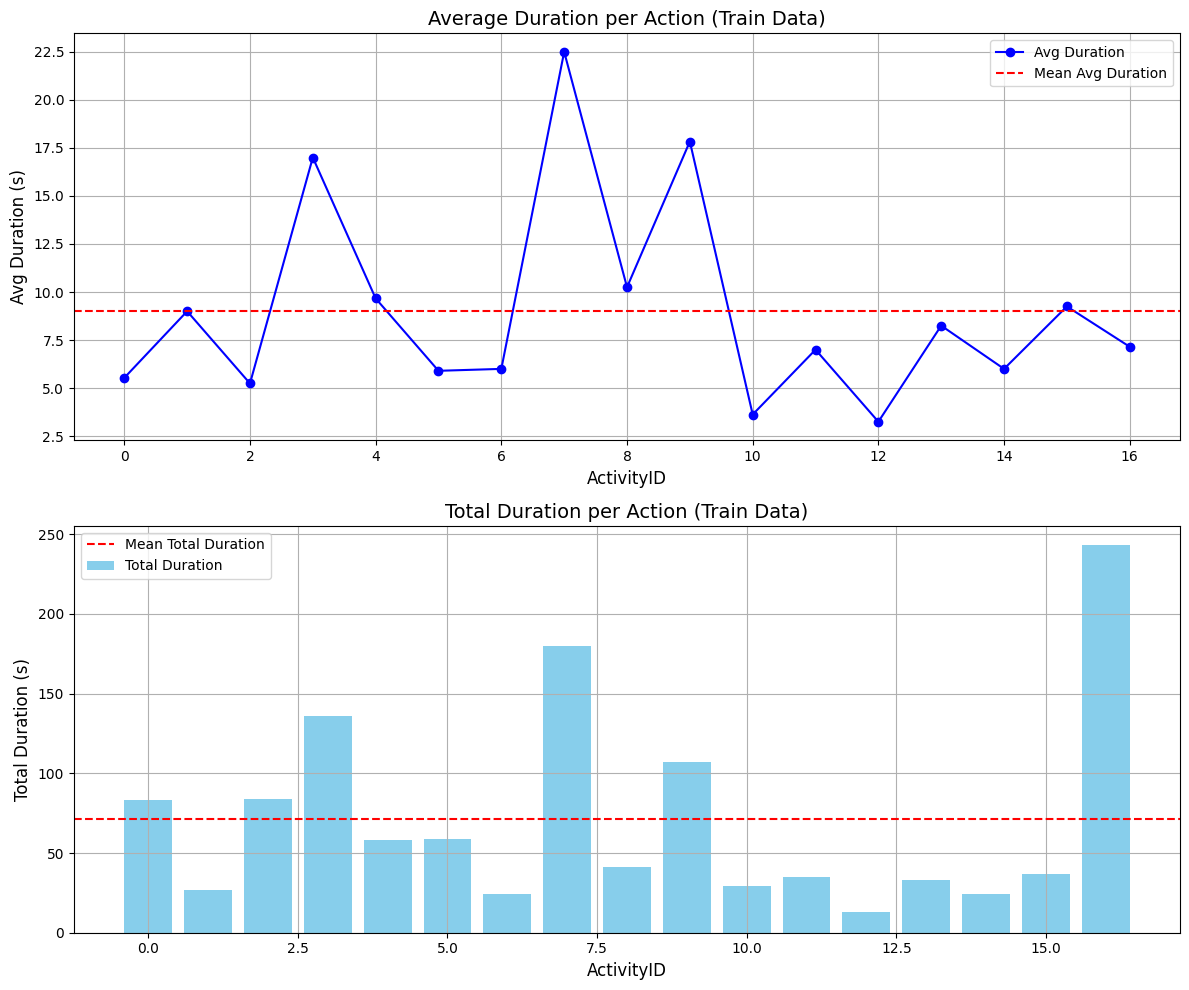

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化统计字典
train_duration = {activity_id: 0 for activity_id in range(17)}  # 假设有17个动作类别
train_counts = {activity_id: 0 for activity_id in range(17)}  # 记录训练数据中每个动作的次数

# 检查并统计训练数据的每个动作持续时间和次数
for ann_df in all_ann_data:
    for i in range(len(ann_df)):
        action_id = ann_df["activityID"].iloc[i]
        if not pd.isnull(action_id):  # 确保action_id不为空
            duration = ann_df["stop_time"].iloc[i] - ann_df["start_time"].iloc[i]
            train_duration[action_id] += duration
            train_counts[action_id] += 1

# 计算平均时间
train_avg_duration = {action_id: train_duration[action_id] / train_counts[action_id] if train_counts[action_id] > 0 else 0 for action_id in train_duration}

# 转换为DataFrame便于查看
train_avg_duration_df = pd.DataFrame.from_dict(train_avg_duration, orient="index", columns=["Train Avg Duration (s)"])
train_duration_df = pd.DataFrame.from_dict(train_duration, orient="index", columns=["Train Total Duration (s)"])
train_avg_duration_df.index.name = "ActivityID"
train_duration_df.index.name = "ActivityID"

# 绘制图表
plt.figure(figsize=(12, 10))

# 上部分：折线图
plt.subplot(2, 1, 1)
plt.plot(train_avg_duration_df.index, train_avg_duration_df["Train Avg Duration (s)"], marker='o', color='b', label="Avg Duration")
plt.axhline(y=train_avg_duration_df["Train Avg Duration (s)"].mean(), color='r', linestyle='--', label="Mean Avg Duration")
plt.title("Average Duration per Action (Train Data)", fontsize=14)
plt.xlabel("ActivityID", fontsize=12)
plt.ylabel("Avg Duration (s)", fontsize=12)
plt.legend()
plt.grid()

# 下部分：柱状图
plt.subplot(2, 1, 2)
plt.bar(train_duration_df.index, train_duration_df["Train Total Duration (s)"], color="skyblue", label="Total Duration")
plt.axhline(y=train_duration_df["Train Total Duration (s)"].mean(), color='r', linestyle='--', label="Mean Total Duration")
plt.title("Total Duration per Action (Train Data)", fontsize=14)
plt.xlabel("ActivityID", fontsize=12)
plt.ylabel("Total Duration (s)", fontsize=12)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

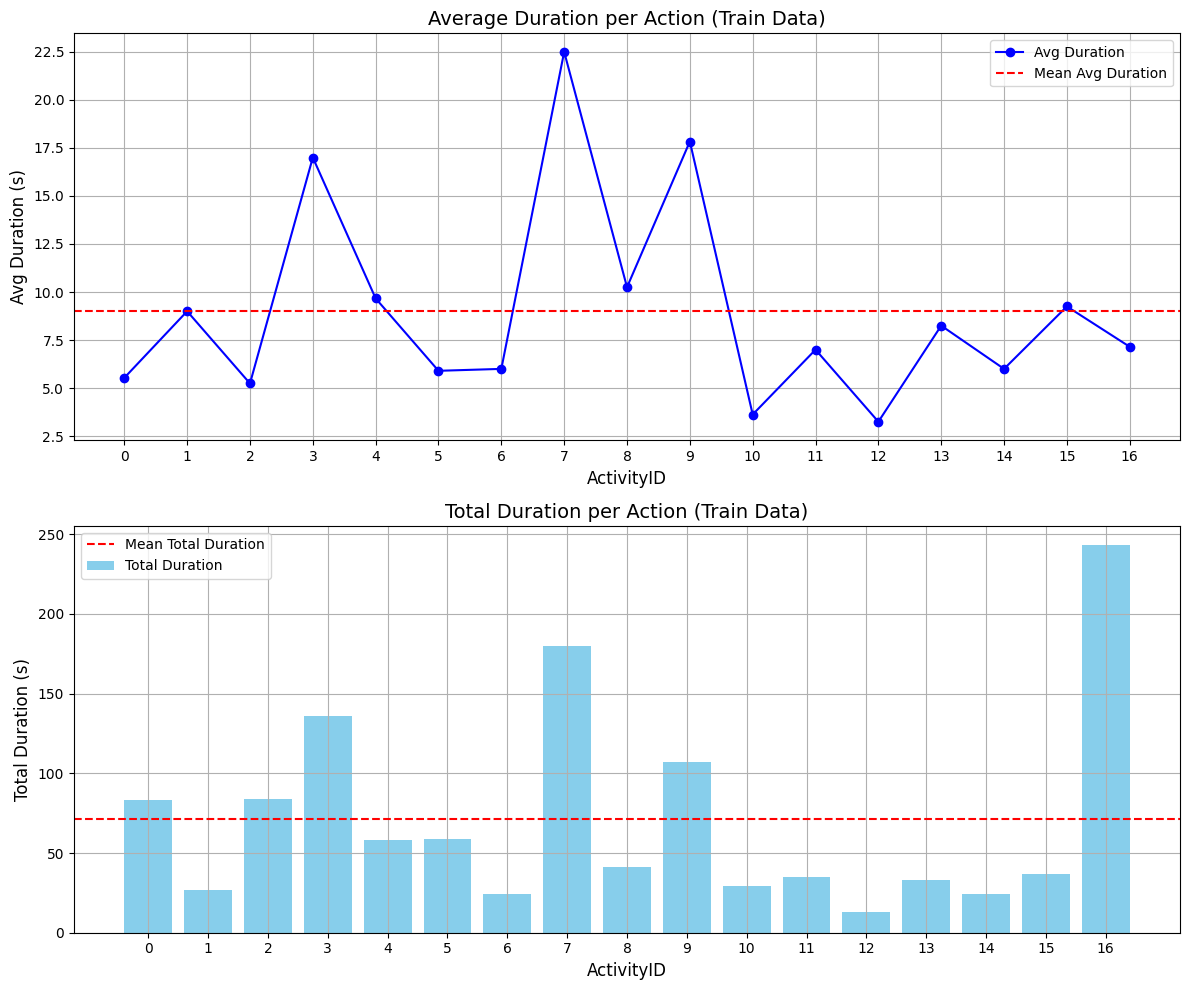

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化统计字典
train_duration = {activity_id: 0 for activity_id in range(17)}  # 假设有17个动作类别
train_counts = {activity_id: 0 for activity_id in range(17)}  # 记录训练数据中每个动作的次数

# 检查并统计训练数据的每个动作持续时间和次数
for ann_df in all_ann_data:
    for i in range(len(ann_df)):
        action_id = ann_df["activityID"].iloc[i]
        if not pd.isnull(action_id):  # 确保action_id不为空
            duration = ann_df["stop_time"].iloc[i] - ann_df["start_time"].iloc[i]
            train_duration[action_id] += duration
            train_counts[action_id] += 1

# 计算平均时间
train_avg_duration = {action_id: train_duration[action_id] / train_counts[action_id] if train_counts[action_id] > 0 else 0 for action_id in train_duration}

# 转换为DataFrame便于查看
train_avg_duration_df = pd.DataFrame.from_dict(train_avg_duration, orient="index", columns=["Train Avg Duration (s)"])
train_duration_df = pd.DataFrame.from_dict(train_duration, orient="index", columns=["Train Total Duration (s)"])
train_avg_duration_df.index.name = "ActivityID"
train_duration_df.index.name = "ActivityID"

# 绘制图表
plt.figure(figsize=(12, 10))

# 上部分：折线图
plt.subplot(2, 1, 1)
plt.plot(train_avg_duration_df.index, train_avg_duration_df["Train Avg Duration (s)"], marker='o', color='b', label="Avg Duration")
plt.axhline(y=train_avg_duration_df["Train Avg Duration (s)"].mean(), color='r', linestyle='--', label="Mean Avg Duration")
plt.title("Average Duration per Action (Train Data)", fontsize=14)
plt.xlabel("ActivityID", fontsize=12)
plt.ylabel("Avg Duration (s)", fontsize=12)
plt.legend()
plt.grid()
plt.xticks(ticks=range(len(train_avg_duration_df.index)), labels=train_avg_duration_df.index)  # 设置连续的横轴

# 下部分：柱状图
plt.subplot(2, 1, 2)
plt.bar(train_duration_df.index, train_duration_df["Train Total Duration (s)"], color="skyblue", label="Total Duration")
plt.axhline(y=train_duration_df["Train Total Duration (s)"].mean(), color='r', linestyle='--', label="Mean Total Duration")
plt.title("Total Duration per Action (Train Data)", fontsize=14)
plt.xlabel("ActivityID", fontsize=12)
plt.ylabel("Total Duration (s)", fontsize=12)
plt.legend()
plt.grid()
plt.xticks(ticks=range(len(train_duration_df.index)), labels=train_duration_df.index)  # 设置连续的横轴

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# 检查训练数据中是否有 NaN
print("训练数据中 NaN 的数量:", np.isnan(all_features).sum())

# 检查测试数据中是否有 NaN
print("测试数据中 NaN 的数量:", np.isnan(test_all_features).sum())

训练数据中 NaN 的数量: 12
测试数据中 NaN 的数量: 0


In [ ]:
all_features = np.nan_to_num(all_features, nan=0.0)
test_all_features = np.nan_to_num(test_all_features, nan=0.0)

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# 应用 SMOTE 处理训练数据
smote = SMOTE(k_neighbors=2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(all_features, all_labels)

In [ ]:
'''

# Define the random forest model
model_rf = RandomForestClassifier()

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(model_rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Output the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

'''

'\n\n# Define the random forest model\nmodel_rf = RandomForestClassifier()\n\n# Define parameter grid for Random Forest\nparam_grid = {\n    \'n_estimators\': [100, 300, 500],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'sqrt\', \'log2\'],\n    \'bootstrap\': [True, False]\n}\n\n# Use GridSearchCV to search for the best parameters\ngrid_search = GridSearchCV(model_rf, param_grid, cv=5, scoring=\'accuracy\', n_jobs=-1)\ngrid_search.fit(X_train_resampled, y_train_resampled)\n\n# Output the best parameters and the best score\nprint("Best parameters found: ", grid_search.best_params_)\nprint("Best cross-validation score: ", grid_search.best_score_)\n\n'

In [ ]:
'''

# Create a model using the best parameters
model_rf = RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    max_features=grid_search.best_params_['max_features'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    bootstrap=grid_search.best_params_['bootstrap'],
    n_jobs=-1
)

# Model training
model_rf.fit(X_train_resampled, y_train_resampled)

'''

"\n\n# Create a model using the best parameters\nmodel_rf = RandomForestClassifier(\n    n_estimators=grid_search.best_params_['n_estimators'],\n    max_depth=grid_search.best_params_['max_depth'],\n    max_features=grid_search.best_params_['max_features'],\n    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],\n    min_samples_split=grid_search.best_params_['min_samples_split'],\n    bootstrap=grid_search.best_params_['bootstrap'],\n    n_jobs=-1\n)\n\n# Model training\nmodel_rf.fit(X_train_resampled, y_train_resampled)\n\n"

In [ ]:
'''

class_weights = {
    0: 2.0,   # 提高权重，召回率低
    1: 1.0,   # 召回率较高，权重保持不变
    2: 1.2,   # 提高权重，支持度低
    3: 0.8,   # 略微降低权重，召回率适中
    4: 1.0,
    5: 1.2,   # 提高权重，召回率较低
    6: 2.5,   # 提高权重，召回率最低
    7: 0.8,   # 降低权重，召回率最高
    8: 1.0,
    9: 0.9,   # 略微降低权重
    10: 3.0,  # 显著提高权重，召回率为零
    11: 1.5,  # 提高权重，支持度低
    12: 3.0,  # 显著提高权重，召回率为零
    13: 1.5,  # 提高权重
    14: 2.0,  # 提高权重，召回率较低
    15: 1.0,
    16: 0.4   # 降低权重，减少对其他类别的干扰
}

'''

'\n\nclass_weights = {\n    0: 2.0,   # 提高权重，召回率低\n    1: 1.0,   # 召回率较高，权重保持不变\n    2: 1.2,   # 提高权重，支持度低\n    3: 0.8,   # 略微降低权重，召回率适中\n    4: 1.0,\n    5: 1.2,   # 提高权重，召回率较低\n    6: 2.5,   # 提高权重，召回率最低\n    7: 0.8,   # 降低权重，召回率最高\n    8: 1.0,\n    9: 0.9,   # 略微降低权重\n    10: 3.0,  # 显著提高权重，召回率为零\n    11: 1.5,  # 提高权重，支持度低\n    12: 3.0,  # 显著提高权重，召回率为零\n    13: 1.5,  # 提高权重\n    14: 2.0,  # 提高权重，召回率较低\n    15: 1.0,\n    16: 0.4   # 降低权重，减少对其他类别的干扰\n}\n\n'

In [ ]:


# 根据最佳参数创建随机森林模型
model_rf = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    n_jobs=-1,  # 使用所有可用的CPU核心
    random_state=42  # 确保结果可复现
)

# 训练模型
model_rf.fit(X_train_resampled, y_train_resampled)



RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=2,
                       n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
# Get the total number of categories
TOTAL_CLASSESS = len(action_mapping)

              precision    recall  f1-score   support

           0       0.45      0.26      0.33        72
           1       1.00      0.71      0.83        55
           2       0.86      0.75      0.80        16
           3       0.97      0.61      0.75        98
           4       0.54      0.91      0.68        23
           5       0.76      0.52      0.62        31
           6       0.25      0.10      0.14        10
           7       0.63      0.96      0.76       143
           8       0.68      0.40      0.51        47
           9       0.94      0.91      0.92        53
          10       0.00      0.00      0.00         7
          11       0.64      0.88      0.74        16
          12       0.00      0.00      0.00         2
          13       0.62      0.24      0.34        21
          14       0.25      0.17      0.20        12
          15       0.69      0.44      0.54        25
          16       0.40      0.61      0.48       107

    accuracy              

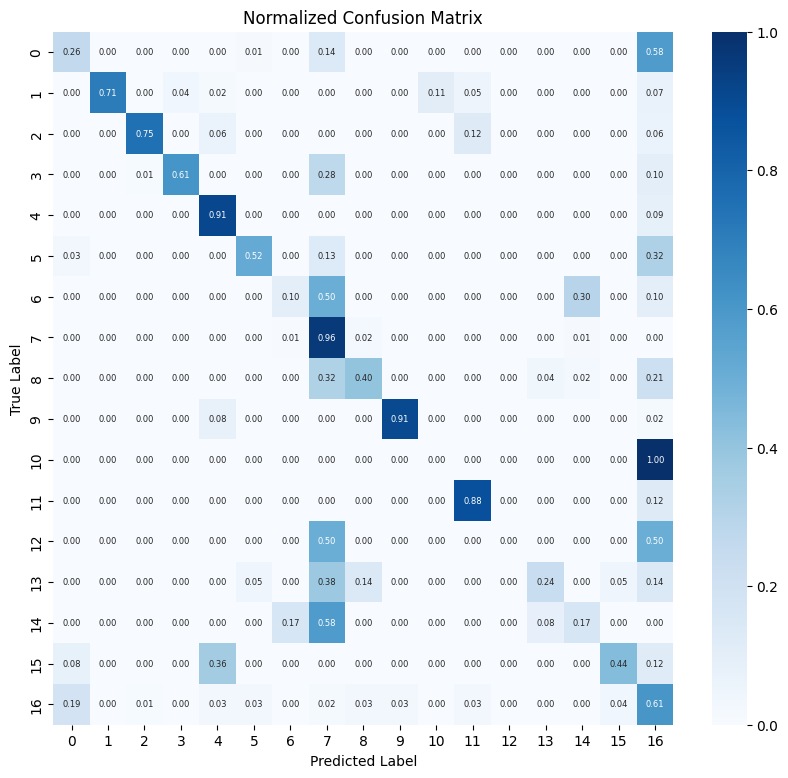

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Use the model to predict the labels of the test data
y_predict = model_rf.predict(test_all_features)

# Output classification report
print(classification_report(test_all_labels, y_predict))

# Calculate the confusion matrix
cm = confusion_matrix(test_all_labels, y_predict, labels=np.unique(test_all_labels))

# Normalize the confusion matrix
cm_norm = cm / np.sum(cm, axis=1, keepdims=True)

# Draw a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 9))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', annot_kws={"fontsize":6}, yticklabels=np.arange(TOTAL_CLASSESS), xticklabels=np.arange(TOTAL_CLASSESS))
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.45      0.26      0.33        72
           1       1.00      0.71      0.83        55
           2       0.86      0.75      0.80        16
           3       0.97      0.61      0.75        98
           4       0.54      0.91      0.68        23
           5       0.76      0.52      0.62        31
           6       0.25      0.10      0.14        10
           7       0.63      0.96      0.76       143
           8       0.68      0.40      0.51        47
           9       0.94      0.91      0.92        53
          10       0.00      0.00      0.00         7
          11       0.64      0.88      0.74        16
          12       0.00      0.00      0.00         2
          13       0.62      0.24      0.34        21
          14       0.25      0.17      0.20        12
          15       0.69      0.44      0.54        25
          16       0.40      0.61      0.48       107

    accuracy              

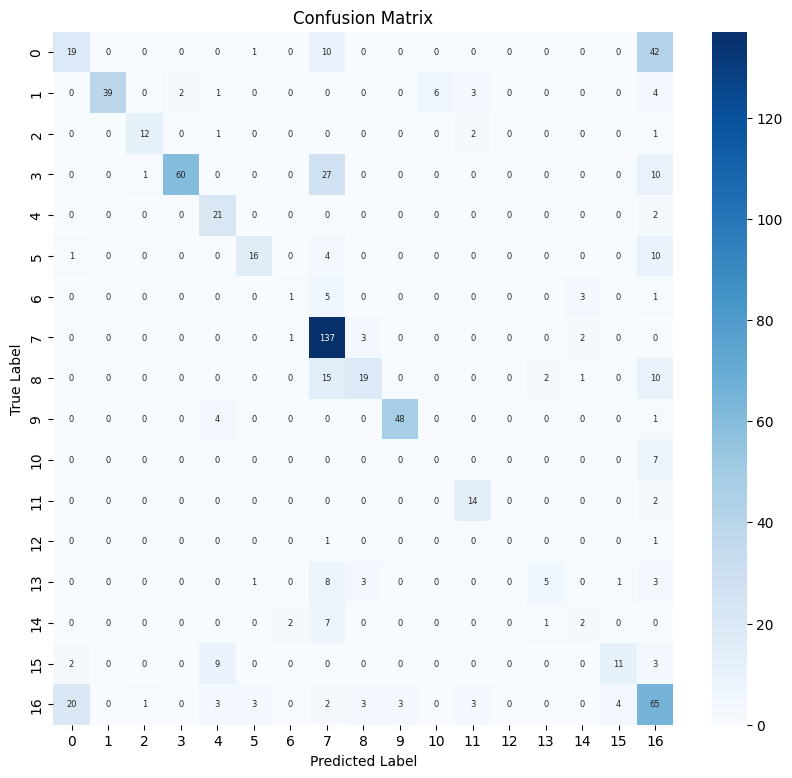

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use the model to predict the labels of the test data
y_predict = model_rf.predict(test_all_features)

# Output classification report
print(classification_report(test_all_labels, y_predict))

# Calculate the confusion matrix
cm = confusion_matrix(test_all_labels, y_predict, labels=np.unique(test_all_labels))

# Draw a heatmap of the confusion matrix (without normalization)
plt.figure(figsize=(10, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize":6}, yticklabels=np.arange(TOTAL_CLASSESS), xticklabels=np.arange(TOTAL_CLASSESS))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Store results for each test user
test_results = {}

# Iterate through each test user and calculate accuracy and F1-score
for test_user_id, test_kp_df, test_ann_df in zip(TEST_IDS, test_all_kp_data, test_all_ann_data):
    test_features = []
    test_labels = []

    for i in range(len(test_ann_df)):
        # Extract the skeleton point data for the current activity segment
        seg = test_kp_df.loc[int(test_ann_df['start_time'][i] * FS): int(test_ann_df['stop_time'][i] * FS)]
        seg_label = test_ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Calculate joint angle and distance features
            joint_angles = extract_joint_angles(np.array(seg))
            joint_distances = calculate_joint_distances(np.array(seg))

            # Calculate new features
            hip_distance = calculate_hip_shoulder_distance(np.array(seg))
            shoulder_distance = calculate_shoulder_distance(np.array(seg))
            jerk_features = calculate_jerk(np.array(seg), frame_rate=FS)

            # Calculate newly added features
            min_len = min(len(seg), len(joint_angles), len(joint_distances))  # Ensure matching lengths
            center_of_mass_features = calculate_center_of_mass(np.array(seg), min_len)
            hand_distance_features = calculate_hand_distance(np.array(seg), min_len)
            head_orientation_features = calculate_head_orientation(np.array(seg), min_len)

            # Segment each feature
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_distances_seg = segment(joint_distances, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            hip_distance_seg = segment(hip_distance, max_time=len(hip_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            shoulder_distance_seg = segment(shoulder_distance, max_time=len(shoulder_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Calculate the speed characteristics of each segment
            velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]
            acceleration_seg = [extract_acceleration(ws_seg[i]) for i in range(len(ws_seg))]
            jerk_seg = [extract_jerk(ws_seg[i]) for i in range(len(ws_seg))]

            # Extract features from each segment
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]
            feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in range(len(joint_angles_seg))]
            feature_velocity_seg = [extract_feature(velocity_seg[i], FS) for i in range(len(velocity_seg))]
            feature_joint_distances_seg = [extract_feature(joint_distances_seg[i], FS) for i in range(len(joint_distances_seg))]
            feature_hip_distance_seg = [extract_feature(hip_distance_seg[i], FS) for i in range(len(hip_distance_seg))]
            feature_shoulder_distance_seg = [extract_feature(shoulder_distance_seg[i], FS) for i in range(len(shoulder_distance_seg))]
            feature_acceleration_seg = [extract_feature(acceleration_seg[i], FS) for i in range(len(acceleration_seg))]
            feature_jerk_seg = [extract_feature(jerk_seg[i], FS) for i in range(len(jerk_seg))]

            # Make sure all features have the same length
            min_len = min(
                len(feature_seg),
                len(feature_joint_angles_seg),
                len(feature_velocity_seg),
                len(feature_joint_distances_seg),
                len(feature_hip_distance_seg),
                len(feature_shoulder_distance_seg),
                len(feature_acceleration_seg),
                len(feature_jerk_seg),
            )

            # Merge all features, including the new features, into a single feature vector
            feature_seg_combined = [
                np.concatenate([
                    feature_seg[j],
                    feature_joint_angles_seg[j],
                    feature_velocity_seg[j],
                    feature_joint_distances_seg[j],
                    feature_hip_distance_seg[j],
                    feature_shoulder_distance_seg[j],
                    feature_acceleration_seg[j],
                    feature_jerk_seg[j],
                    [center_of_mass_features],  # Add center of mass features
                    [hand_distance_features],  # Add hand distance features
                    [head_orientation_features]  # Add head orientation features
                ])
                for j in range(min_len)
            ]

            # Add features and labels to the final dataset
            test_features.extend(feature_seg_combined)
            test_labels.extend([seg_label] * min_len)

    # Convert to arrays for prediction
    test_features = np.array(test_features)
    test_labels = np.array(test_labels)

    # Predict and evaluate for the current user
    y_pred = model_rf.predict(test_features)
    acc = accuracy_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred, average="weighted")

    # Store results
    test_results[test_user_id] = {"Accuracy": acc, "F1-score": f1}

# Create and format results table
results_df = pd.DataFrame(test_results).T
results_df.index.name = 'File'
results_df.loc['TOTAL'] = results_df.mean()
results_df = results_df.round(2)

# Display results with bold headers and TOTAL row
print(f"\033[1m{'File':<8}   {'Accuracy':<10}   {'F1-score':<10}\033[0m")
print(" ")
for idx, row in results_df.iterrows():
    if idx == 'TOTAL':
        print(" ")
        print(f"\033[1m{idx:<8}   {row['Accuracy']:<10.2f}   {row['F1-score']:<10.2f}\033[0m")
    else:
        print(f"{idx:<8}   {row['Accuracy']:<10.2f}   {row['F1-score']:<10.2f}")
print(" ")

File       Accuracy     F1-score  
 
T1N02      0.53         0.49      
T1F02      0.72         0.72      
 
TOTAL      0.63         0.60      
 


Feature Importance by Group:
Base Features: 0.4391
Joint Angles: 0.0928
Velocity: 0.2028
Joint Distances: 0.1329
Hip Distances: 0.0293
Shoulder Distances: 0.0267
Acceleration: 0.0100
Jerk: 0.0133
Center of Mass: 0.0187
Hand Distance: 0.0209
Head Orientation: 0.0136


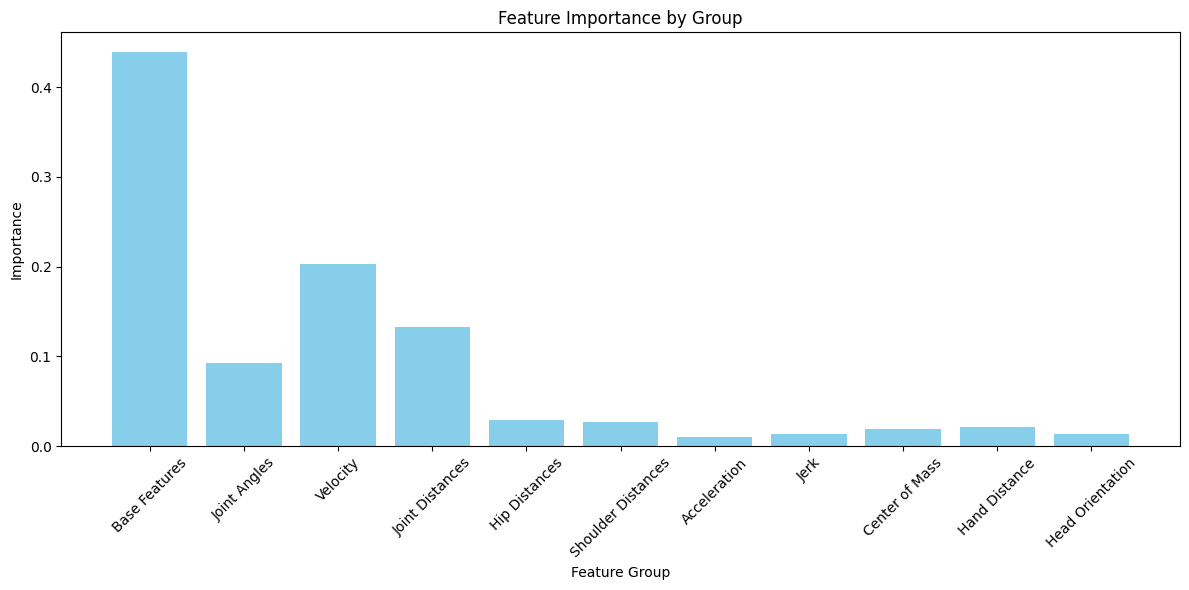

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 获取特征重要性
feature_importances = model_rf.feature_importances_

# 特征分组长度
num_feature_seg_features = len(feature_seg[0])
num_joint_angle_features = len(feature_joint_angles_seg[0])
num_velocity_features = len(feature_velocity_seg[0])
num_joint_distance_features = len(feature_joint_distances_seg[0])
num_hip_distance_features = len(feature_hip_distance_seg[0])
num_shoulder_distance_features = len(feature_shoulder_distance_seg[0])
num_acceleration_features = len(feature_acceleration_seg[0])
num_jerk_features = len(feature_jerk_seg[0])

# 标量特征（单个值的特征）
num_center_of_mass_features = 1  # Center of Mass 特征为标量
num_hand_distance_features = 1  # Hand Distance 特征为标量
num_head_orientation_features = 1  # Head Orientation 特征为标量

# 计算每个特征类别的重要性
feature_seg_importance = np.sum(feature_importances[:num_feature_seg_features])
joint_angle_importance = np.sum(feature_importances[num_feature_seg_features:num_feature_seg_features + num_joint_angle_features])
velocity_importance = np.sum(feature_importances[num_feature_seg_features + num_joint_angle_features:num_feature_seg_features + num_joint_angle_features + num_velocity_features])
joint_distance_importance = np.sum(feature_importances[num_feature_seg_features + num_joint_angle_features + num_velocity_features:num_feature_seg_features + num_joint_angle_features + num_velocity_features + num_joint_distance_features])
hip_distance_importance = np.sum(feature_importances[num_feature_seg_features + num_joint_angle_features + num_velocity_features + num_joint_distance_features:num_feature_seg_features + num_joint_angle_features + num_velocity_features + num_joint_distance_features + num_hip_distance_features])
shoulder_distance_importance = np.sum(feature_importances[num_feature_seg_features + num_joint_angle_features + num_velocity_features + num_joint_distance_features + num_hip_distance_features:num_feature_seg_features + num_joint_angle_features + num_velocity_features + num_joint_distance_features + num_hip_distance_features + num_shoulder_distance_features])
acceleration_importance = np.sum(feature_importances[num_feature_seg_features + num_joint_angle_features + num_velocity_features + num_joint_distance_features + num_hip_distance_features + num_shoulder_distance_features:num_feature_seg_features + num_joint_angle_features + num_velocity_features + num_joint_distance_features + num_hip_distance_features + num_shoulder_distance_features + num_acceleration_features])
jerk_importance = np.sum(feature_importances[num_feature_seg_features + num_joint_angle_features + num_velocity_features + num_joint_distance_features + num_hip_distance_features + num_shoulder_distance_features + num_acceleration_features:num_feature_seg_features + num_joint_angle_features + num_velocity_features + num_joint_distance_features + num_hip_distance_features + num_shoulder_distance_features + num_acceleration_features + num_jerk_features])
center_of_mass_importance = feature_importances[num_feature_seg_features + num_joint_angle_features + num_velocity_features + num_joint_distance_features + num_hip_distance_features + num_shoulder_distance_features + num_acceleration_features + num_jerk_features]
hand_distance_importance = feature_importances[num_feature_seg_features + num_joint_angle_features + num_velocity_features + num_joint_distance_features + num_hip_distance_features + num_shoulder_distance_features + num_acceleration_features + num_jerk_features + num_center_of_mass_features]
head_orientation_importance = feature_importances[num_feature_seg_features + num_joint_angle_features + num_velocity_features + num_joint_distance_features + num_hip_distance_features + num_shoulder_distance_features + num_acceleration_features + num_jerk_features + num_center_of_mass_features + num_hand_distance_features]

# 汇总特征重要性
feature_group_importance = {
    "Base Features": feature_seg_importance,
    "Joint Angles": joint_angle_importance,
    "Velocity": velocity_importance,
    "Joint Distances": joint_distance_importance,
    "Hip Distances": hip_distance_importance,
    "Shoulder Distances": shoulder_distance_importance,
    "Acceleration": acceleration_importance,
    "Jerk": jerk_importance,
    "Center of Mass": center_of_mass_importance,
    "Hand Distance": hand_distance_importance,
    "Head Orientation": head_orientation_importance,
}

# 输出每个特征组的重要性
print("Feature Importance by Group:")
for feature_group, importance in feature_group_importance.items():
    print(f"{feature_group}: {importance:.4f}")

# 可视化特征重要性
plt.figure(figsize=(12, 6))
plt.bar(feature_group_importance.keys(), feature_group_importance.values(), color='skyblue')
plt.title("Feature Importance by Group")
plt.xlabel("Feature Group")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Feature Contribution Matrix for Each Action:
                        0       1       2       3       4       5       6   \
Base Features       0.1464  0.3643  0.3512  0.3293  0.2974  0.2702  0.0627   
Joint Angles        0.0309  0.0770  0.0743  0.0696  0.0629  0.0571  0.0133   
Velocity            0.0676  0.1683  0.1622  0.1521  0.1374  0.1248  0.0290   
Joint Distances     0.0443  0.1103  0.1063  0.0997  0.0900  0.0818  0.0190   
Hip Distances       0.0098  0.0243  0.0234  0.0220  0.0198  0.0180  0.0042   
Shoulder Distances  0.0089  0.0221  0.0213  0.0200  0.0181  0.0164  0.0038   
Acceleration        0.0033  0.0083  0.0080  0.0075  0.0067  0.0061  0.0014   
Jerk                0.0044  0.0111  0.0107  0.0100  0.0090  0.0082  0.0019   
Center of Mass      0.0062  0.0155  0.0150  0.0140  0.0127  0.0115  0.0027   
Hand Distance       0.0070  0.0173  0.0167  0.0157  0.0141  0.0128  0.0030   
Head Orientation    0.0045  0.0113  0.0109  0.0102  0.0092  0.0084  0.0019   

                  

<Figure size 3000x800 with 0 Axes>

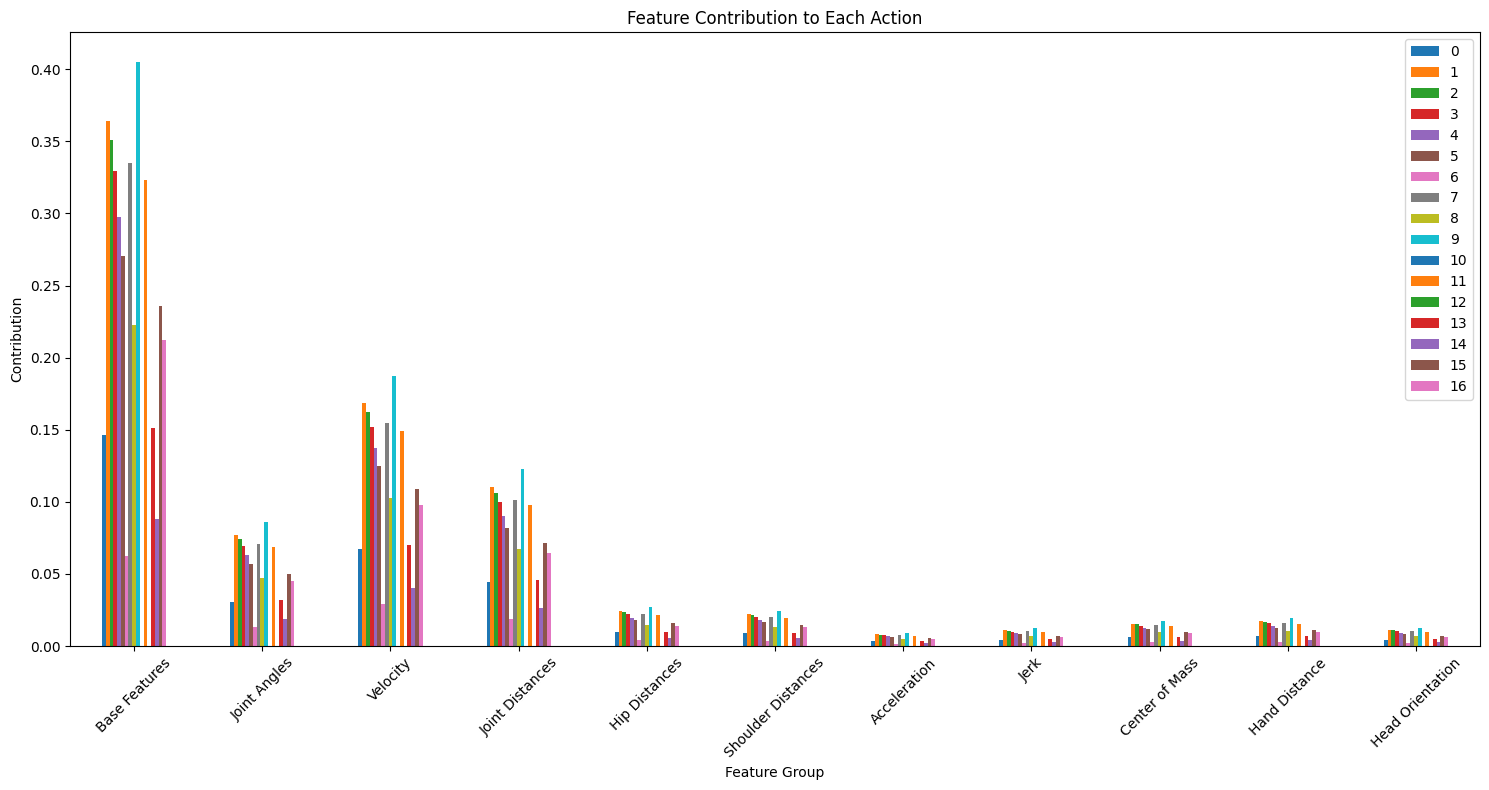

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 模型预测
y_predict = model_rf.predict(test_all_features)

# 获取分类报告
report = classification_report(test_all_labels, y_predict, output_dict=True)

# 提取分类指标
classes = sorted(np.unique(test_all_labels))  # 动作类别
precision = [report[str(c)]['precision'] for c in classes]
recall = [report[str(c)]['recall'] for c in classes]
f1_score = [report[str(c)]['f1-score'] for c in classes]

# 获取特征重要性
feature_importances = model_rf.feature_importances_

# 特征类别分组长度
num_feature_seg_features = len(feature_seg[0])
num_joint_angle_features = len(feature_joint_angles_seg[0])
num_velocity_features = len(feature_velocity_seg[0])
num_joint_distance_features = len(feature_joint_distances_seg[0])
num_hip_distance_features = len(feature_hip_distance_seg[0])
num_shoulder_distance_features = len(feature_shoulder_distance_seg[0])
num_acceleration_features = len(feature_acceleration_seg[0])
num_jerk_features = len(feature_jerk_seg[0])
num_center_of_mass_features = 1
num_hand_distance_features = 1
num_head_orientation_features = 1

# 定义特征分组
feature_group_lengths = {
    "Base Features": num_feature_seg_features,
    "Joint Angles": num_joint_angle_features,
    "Velocity": num_velocity_features,
    "Joint Distances": num_joint_distance_features,
    "Hip Distances": num_hip_distance_features,
    "Shoulder Distances": num_shoulder_distance_features,
    "Acceleration": num_acceleration_features,
    "Jerk": num_jerk_features,
    "Center of Mass": num_center_of_mass_features,
    "Hand Distance": num_hand_distance_features,
    "Head Orientation": num_head_orientation_features
}

# 计算各特征分组的重要性
start = 0
feature_group_importances = {}
for group_name, length in feature_group_lengths.items():
    feature_group_importances[group_name] = np.sum(feature_importances[start:start + length])
    start += length

# 创建动作和特征贡献度的矩阵
contribution_matrix = pd.DataFrame(columns=classes, index=feature_group_importances.keys())

for group_name, importance in feature_group_importances.items():
    for action in classes:
        contribution_matrix.loc[group_name, action] = importance * report[str(action)]['f1-score']

# 替换 NaN 为 0
contribution_matrix = contribution_matrix.fillna(0)

# 四舍五入
contribution_matrix = contribution_matrix.round(4)

# 输出结果
print("Feature Contribution Matrix for Each Action:")
print(contribution_matrix)

# 可视化
plt.figure(figsize=(30, 8))
contribution_matrix.plot(kind='bar', figsize=(15, 8), legend=True)
plt.title("Feature Contribution to Each Action")
plt.xlabel("Feature Group")
plt.ylabel("Contribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# 将实际标签和预测结果合并为一个 DataFrame
results_df = pd.DataFrame({
    "True Labels": test_all_labels,
    "Pred Labels": y_predict
})

# 打印前几行查看
print("Comparison of Actual and Predicted Labels:")
print(results_df.head(20))  # 仅显示前20个样本，便于查看

Comparison of Actual and Predicted Labels:
    True Labels  Pred Labels
0             1           10
1             1           10
2             1            3
3             1            3
4             1            1
5             1            1
6             1            4
7             1           10
8             1           10
9            16           16
10            4           16
11           16           16
12           16           16
13           16           16
14           16           16
15            4           16
16            4            4
17            4            4
18            4            4
19            4            4


In [ ]:
# 保存到CSV文件
results_df.to_csv("predictions_result.csv", index=False)

In [ ]:
 '''

    # 规则 1：修正动作 6（Open the gastrostomy cap）
    for i in range(1, seq_len):
        if adjusted_preds[i] == 7 and confidences[i] < threshold:
            if adjusted_preds[i - 1] != 6:
                adjusted_preds[i - 1] = 6

    # 规则 2：修正动作 12（Close the clamp）
    for i in range(1, seq_len):
        if adjusted_preds[i] == 13 and confidences[i] < threshold:
            if adjusted_preds[i - 1] != 12:
                adjusted_preds[i - 1] = 12

    # 规则 3：修正动作 14（Close the gastrostomy cap）
    for i in range(1, seq_len - 1):
        if adjusted_preds[i] == 13 and adjusted_preds[i + 1] == 7 and confidences[i + 1] < threshold:
            if adjusted_preds[i + 2] != 14:
                adjusted_preds[i + 2] = 14

    # 规则 4：修正动作 10（Removal of gloves）
    for i in range(seq_len - 1):
        if adjusted_preds[i] == 15 and confidences[i] < threshold:
            if adjusted_preds[i + 1] != 10:
                adjusted_preds[i + 1] = 10

'''

'\n\n   # 规则 1：修正动作 6（Open the gastrostomy cap）\n   for i in range(1, seq_len):\n       if adjusted_preds[i] == 7 and confidences[i] < threshold:\n           if adjusted_preds[i - 1] != 6:\n               adjusted_preds[i - 1] = 6\n\n   # 规则 2：修正动作 12（Close the clamp）\n   for i in range(1, seq_len):\n       if adjusted_preds[i] == 13 and confidences[i] < threshold:\n           if adjusted_preds[i - 1] != 12:\n               adjusted_preds[i - 1] = 12\n\n   # 规则 3：修正动作 14（Close the gastrostomy cap）\n   for i in range(1, seq_len - 1):\n       if adjusted_preds[i] == 13 and adjusted_preds[i + 1] == 7 and confidences[i + 1] < threshold:\n           if adjusted_preds[i + 2] != 14:\n               adjusted_preds[i + 2] = 14\n\n   # 规则 4：修正动作 10（Removal of gloves）\n   for i in range(seq_len - 1):\n       if adjusted_preds[i] == 15 and confidences[i] < threshold:\n           if adjusted_preds[i + 1] != 10:\n               adjusted_preds[i + 1] = 10\n\n'

In [ ]:
'''

def post_process_predictions(pred_labels, pred_probs, threshold=0.6):
    """
    根据后处理规则调整预测结果，考虑模型的预测概率。

    参数：
    - pred_labels: 模型的预测标签列表或数组。
    - pred_probs: 模型的预测概率数组，形状为 (样本数, 类别数)。
    - threshold: 置信度阈值，低于该值的预测将被考虑进行后处理。

    返回：
    - adjusted_preds: 经过调整的预测标签列表。
    """
    import numpy as np

    adjusted_preds = pred_labels.copy()
    adjusted_preds = np.array(adjusted_preds)
    pred_probs = np.array(pred_probs)

    # 获取预测序列的长度
    seq_len = len(adjusted_preds)

    # 获取模型预测的置信度（最大概率值）
    confidences = np.max(pred_probs, axis=1)

        # 规则 1：修正动作 6（Open the gastrostomy cap）
    for i in range(1, seq_len):
        if adjusted_preds[i] == 7 and confidences[i] < threshold:
            if adjusted_preds[i - 1] != 6:
                adjusted_preds[i - 1] = 6

    # 规则 2：修正动作 12（Close the clamp）
    for i in range(1, seq_len):
        if adjusted_preds[i] == 13 and confidences[i] < threshold:
            if adjusted_preds[i - 1] != 12:
                adjusted_preds[i - 1] = 12

    # 规则 3：修正动作 14（Close the gastrostomy cap）
    for i in range(1, seq_len - 1):
        if adjusted_preds[i] == 13 and adjusted_preds[i + 1] == 7 and confidences[i + 1] < threshold:
            if adjusted_preds[i + 2] != 14:
                adjusted_preds[i + 2] = 14

    # 规则 4：修正动作 10（Removal of gloves）
    for i in range(seq_len - 1):
        if adjusted_preds[i] == 15 and confidences[i] < threshold:
            if adjusted_preds[i + 1] != 10:
                adjusted_preds[i + 1] = 10

    return adjusted_preds.tolist()

'''

'\n\ndef post_process_predictions(pred_labels, pred_probs, threshold=0.6):\n    """\n    根据后处理规则调整预测结果，考虑模型的预测概率。\n\n    参数：\n    - pred_labels: 模型的预测标签列表或数组。\n    - pred_probs: 模型的预测概率数组，形状为 (样本数, 类别数)。\n    - threshold: 置信度阈值，低于该值的预测将被考虑进行后处理。\n\n    返回：\n    - adjusted_preds: 经过调整的预测标签列表。\n    """\n    import numpy as np\n\n    adjusted_preds = pred_labels.copy()\n    adjusted_preds = np.array(adjusted_preds)\n    pred_probs = np.array(pred_probs)\n\n    # 获取预测序列的长度\n    seq_len = len(adjusted_preds)\n\n    # 获取模型预测的置信度（最大概率值）\n    confidences = np.max(pred_probs, axis=1)\n\n        # 规则 1：修正动作 6（Open the gastrostomy cap）\n    for i in range(1, seq_len):\n        if adjusted_preds[i] == 7 and confidences[i] < threshold:\n            if adjusted_preds[i - 1] != 6:\n                adjusted_preds[i - 1] = 6\n\n    # 规则 2：修正动作 12（Close the clamp）\n    for i in range(1, seq_len):\n        if adjusted_preds[i] == 13 and confidences[i] < threshold:\n            if adjusted_preds[i - 1] !=

In [ ]:
'''

# model_rf
pred_probs = model_rf.predict_proba(test_all_features)
y_predict = model_rf.predict(test_all_features)

'''

'\n\n# model_rf\npred_probs = model_rf.predict_proba(test_all_features)\ny_predict = model_rf.predict(test_all_features)\n\n'

In [ ]:
'''

adjusted_preds = post_process_predictions(y_predict, pred_probs, threshold=0.6)

'''

'\n\nadjusted_preds = post_process_predictions(y_predict, pred_probs, threshold=0.6)\n\n'

In [ ]:
'''

from sklearn.metrics import classification_report

print("The result before：")
print(classification_report(test_all_labels, y_predict))

print("The result after：")
print(classification_report(test_all_labels, adjusted_preds))

'''

'\n\nfrom sklearn.metrics import classification_report\n\nprint("The result before：")\nprint(classification_report(test_all_labels, y_predict))\n\nprint("The result after：")\nprint(classification_report(test_all_labels, adjusted_preds))\n\n'

动态滑动窗口平滑后的分类报告：
              precision    recall  f1-score   support

           0       0.45      0.31      0.36        72
           1       0.98      0.73      0.83        55
           2       0.92      0.69      0.79        16
           3       0.94      0.62      0.75        98
           4       0.50      0.91      0.65        23
           5       0.91      0.65      0.75        31
           6       0.00      0.00      0.00        10
           7       0.62      0.99      0.76       143
           8       0.77      0.43      0.55        47
           9       0.94      0.91      0.92        53
          10       0.00      0.00      0.00         7
          11       0.68      0.94      0.79        16
          12       0.00      0.00      0.00         2
          13       1.00      0.19      0.32        21
          14       0.00      0.00      0.00        12
          15       1.00      0.44      0.61        25
          16       0.43      0.63      0.51       107

    accura

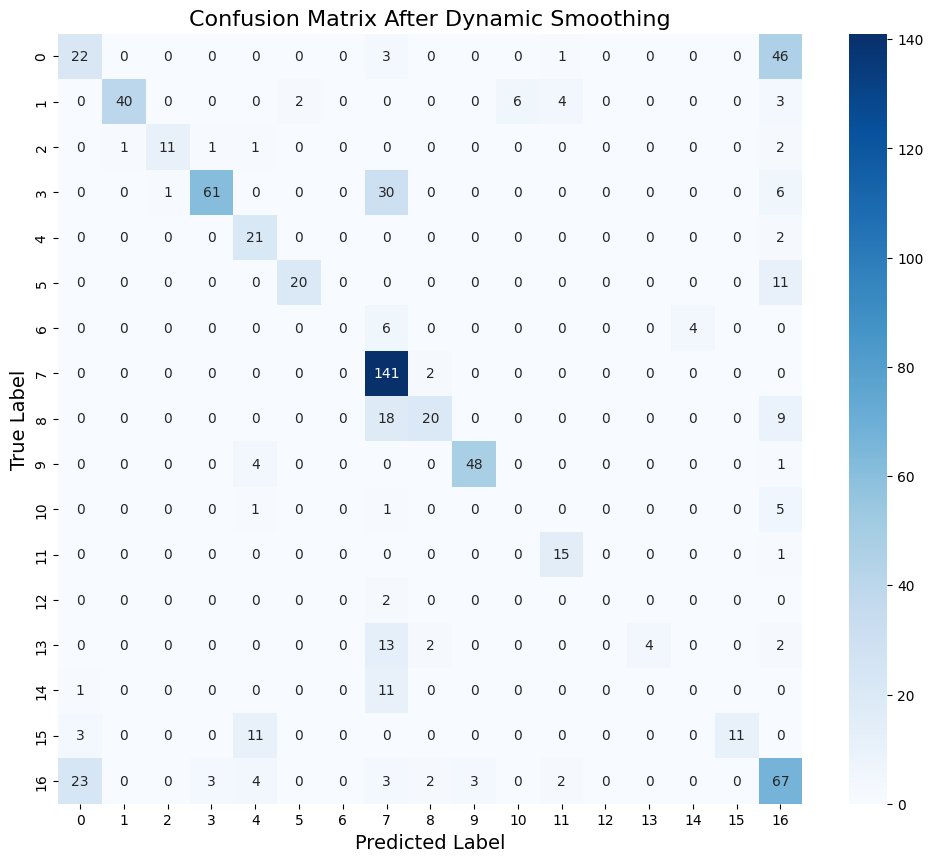

In [ ]:
def dynamic_smooth_predictions(preds, avg_durations, fs, min_window=3, max_window=9):
    """
    根据动作平均持续时间动态调整滑动窗口大小，同时返回最佳窗口大小。

    参数：
    - preds: 预测标签数组。
    - avg_durations: 每个动作的平均持续时间（秒）。
    - fs: 帧率。
    - min_window: 最小窗口大小。
    - max_window: 最大窗口大小。

    返回：
    - smoothed_preds: 平滑后的预测标签列表。
    - best_window_sizes: 每个动作的最佳窗口大小。
    """
    smoothed_preds = preds.copy()
    best_window_sizes = {}  # 用于存储每个动作的最佳窗口大小

    for action, avg_duration in avg_durations.items():
        # 计算窗口大小（限制在[min_window, max_window]范围内）
        window_size = max(min(int(avg_duration * fs), max_window), min_window)
        if window_size % 2 == 0:  # 确保窗口大小为奇数
            window_size += 1

        best_window_sizes[action] = window_size  # 记录最佳窗口大小

        # 对每个动作单独平滑
        indices = np.where(preds == action)[0]
        if len(indices) > 0:
            padded_preds = np.pad(preds, (window_size // 2, window_size // 2), mode='edge')
            for i in indices:
                window = padded_preds[i:i + window_size]
                most_common = np.bincount(window).argmax()
                smoothed_preds[i] = most_common

    return smoothed_preds, best_window_sizes


# 调用函数进行动态平滑，并获取最佳窗口大小
dynamic_smoothed_preds, best_window_sizes = dynamic_smooth_predictions(
    y_predict, avg_durations=train_avg_duration, fs=FS
)

# 输出分类报告和准确率
print("动态滑动窗口平滑后的分类报告：")
print(classification_report(test_all_labels, dynamic_smoothed_preds))
print("动态滑动窗口平滑后的准确率：", accuracy_score(test_all_labels, dynamic_smoothed_preds))

# 输出最佳窗口大小
print("\n每个动作的最佳窗口大小：")
for action, window_size in best_window_sizes.items():
    print(f"动作 {action}: 窗口大小 {window_size}")

# 计算混淆矩阵
cm = confusion_matrix(test_all_labels, dynamic_smoothed_preds, labels=np.unique(test_all_labels))

# 绘制混淆矩阵
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_all_labels), yticklabels=np.unique(test_all_labels))
plt.title("Confusion Matrix After Dynamic Smoothing", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

In [ ]:
def smooth_predictions_short_priority(preds, window_size=9, short_actions=None, short_action_min_length=3):
    """
    对预测结果进行滑动窗口平滑处理，同时优先保留短时间动作。

    参数：
    - preds: 预测标签数组。
    - window_size: 滑动窗口大小。
    - short_actions: 短时间动作的列表。
    - short_action_min_length: 短时间动作的最小持续帧数。

    返回：
    - smoothed_preds: 平滑后的预测标签列表。
    """
    import numpy as np

    if short_actions is None:
        short_actions = []

    smoothed_preds = []
    half_window = window_size // 2

    # 使用 np.pad 进行填充
    padded_preds = np.pad(preds, (half_window, half_window), mode='edge')

    for i in range(len(preds)):
        window_start = max(0, i - half_window)
        window_end = min(len(preds), i + half_window + 1)
        window = preds[window_start:window_end]

        # 使用 np.bincount 获取出现次数最多的元素
        most_common = np.bincount(window).argmax()

        # 如果当前是短时间动作，检查是否需要优先保留
        if preds[i] in short_actions:
            count = 1
            for j in range(i - 1, -1, -1):
                if preds[j] == preds[i]:
                    count += 1
                else:
                    break
            for j in range(i + 1, len(preds)):
                if preds[j] == preds[i]:
                    count += 1
                else:
                    break

            # 如果短时间动作的长度小于最小长度，优先保留当前预测
            if count < short_action_min_length:
                most_common = preds[i]

        smoothed_preds.append(most_common)

    return smoothed_preds

平滑前的分类报告：
              precision    recall  f1-score   support

           0       0.45      0.26      0.33        72
           1       1.00      0.71      0.83        55
           2       0.86      0.75      0.80        16
           3       0.97      0.61      0.75        98
           4       0.54      0.91      0.68        23
           5       0.76      0.52      0.62        31
           6       0.25      0.10      0.14        10
           7       0.63      0.96      0.76       143
           8       0.68      0.40      0.51        47
           9       0.94      0.91      0.92        53
          10       0.00      0.00      0.00         7
          11       0.64      0.88      0.74        16
          12       0.00      0.00      0.00         2
          13       0.62      0.24      0.34        21
          14       0.25      0.17      0.20        12
          15       0.69      0.44      0.54        25
          16       0.40      0.61      0.48       107

    accuracy    

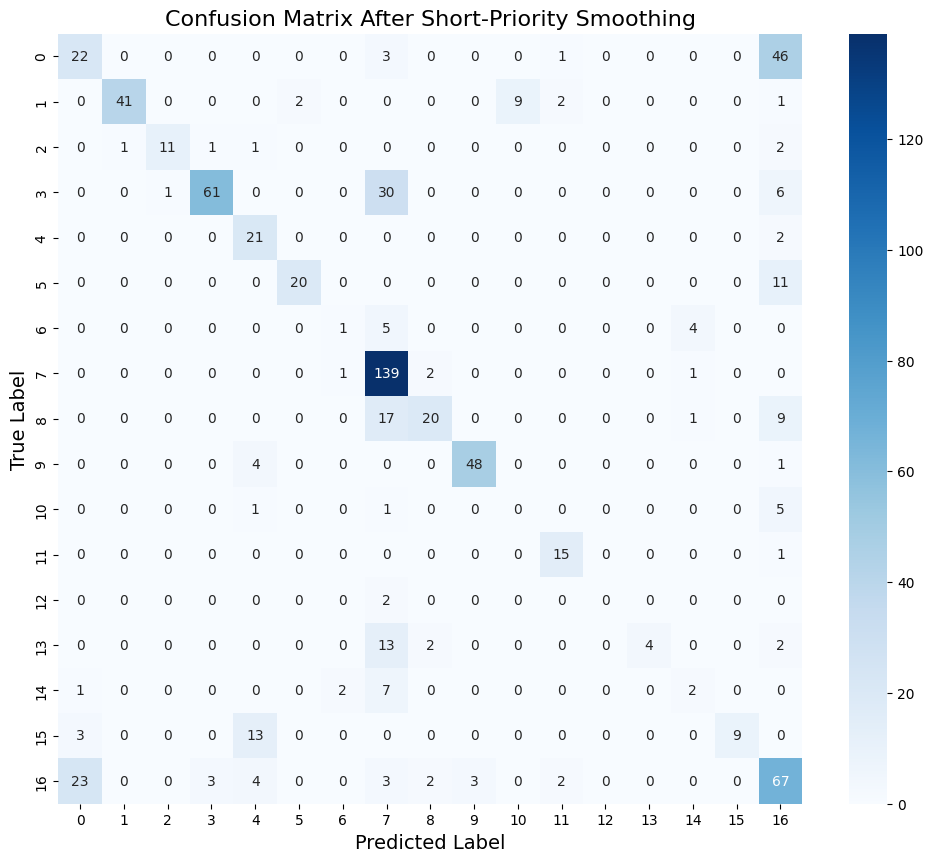

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# 定义短时间动作的列表和最小长度
short_actions = [6, 10, 12, 14]  # 需要优先优化的短时间动作
short_action_min_length = 3  # 短时间动作的最小持续帧数

# 获取模型的预测结果
y_predict = model_rf.predict(test_all_features)

# 应用短时间动作优先法进行平滑
smoothed_preds_short_priority = smooth_predictions_short_priority(
    y_predict,
    window_size=9,
    short_actions=short_actions,
    short_action_min_length=short_action_min_length
)

# 平滑前的分类报告
print("平滑前的分类报告：")
print(classification_report(test_all_labels, y_predict))
print("平滑前的准确率：", accuracy_score(test_all_labels, y_predict))

# 短时间动作优先法平滑后的分类报告
print("\n短时间动作优先法平滑后的分类报告：")
print(classification_report(test_all_labels, smoothed_preds_short_priority))
print("短时间动作优先法平滑后的准确率：", accuracy_score(test_all_labels, smoothed_preds_short_priority))

# 平滑后的混淆矩阵
cm = confusion_matrix(test_all_labels, smoothed_preds_short_priority, labels=np.unique(test_all_labels))

# 绘制混淆矩阵
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_all_labels), yticklabels=np.unique(test_all_labels))
plt.title("Confusion Matrix After Short-Priority Smoothing", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def smooth_predictions_short_priority(preds, window_size=9, short_actions=None, short_action_min_length=3):
    """
    对预测结果进行滑动窗口平滑处理，同时优先保留短时间动作。

    参数：
    - preds: 预测标签数组。
    - window_size: 滑动窗口大小。
    - short_actions: 短时间动作的列表。
    - short_action_min_length: 短时间动作的最小持续帧数。

    返回：
    - smoothed_preds: 平滑后的预测标签列表。
    """
    import numpy as np

    if short_actions is None:
        short_actions = []

    smoothed_preds = []
    half_window = window_size // 2

    # 使用 np.pad 进行填充
    padded_preds = np.pad(preds, (half_window, half_window), mode='edge')

    for i in range(len(preds)):
        window_start = max(0, i - half_window)
        window_end = min(len(preds), i + half_window + 1)
        window = preds[window_start:window_end]

        # 使用 np.bincount 获取出现次数最多的元素
        most_common = np.bincount(window).argmax()

        # 如果当前是短时间动作，检查是否需要优先保留
        if preds[i] in short_actions:
            count = 1
            for j in range(i - 1, -1, -1):
                if preds[j] == preds[i]:
                    count += 1
                else:
                    break
            for j in range(i + 1, len(preds)):
                if preds[j] == preds[i]:
                    count += 1
                else:
                    break

            # 如果短时间动作的长度小于最小长度，优先保留当前预测
            if count < short_action_min_length:
                most_common = preds[i]

        smoothed_preds.append(most_common)

    return smoothed_preds

# Store results for each test user
test_results = {}

# Iterate through each test user and calculate accuracy and F1-score
for test_user_id, test_kp_df, test_ann_df in zip(TEST_IDS, test_all_kp_data, test_all_ann_data):
    test_features = []
    test_labels = []

    for i in range(len(test_ann_df)):
        # Extract the skeleton point data for the current activity segment
        seg = test_kp_df.loc[int(test_ann_df['start_time'][i] * FS): int(test_ann_df['stop_time'][i] * FS)]
        seg_label = test_ann_df["activityID"].iloc[i]

        if len(seg) > 0 and (len(seg) >= WINDOW_SIZE * FS):
            # Calculate joint angle and distance features
            joint_angles = extract_joint_angles(np.array(seg))
            joint_distances = calculate_joint_distances(np.array(seg))

            # Calculate new features
            hip_distance = calculate_hip_shoulder_distance(np.array(seg))
            shoulder_distance = calculate_shoulder_distance(np.array(seg))
            jerk_features = calculate_jerk(np.array(seg), frame_rate=FS)

            # Calculate newly added features
            min_len = min(len(seg), len(joint_angles), len(joint_distances))  # Ensure matching lengths
            center_of_mass_features = calculate_center_of_mass(np.array(seg), min_len)
            hand_distance_features = calculate_hand_distance(np.array(seg), min_len)
            head_orientation_features = calculate_head_orientation(np.array(seg), min_len)

            # Segment each feature
            ws_seg = segment(np.array(seg), max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_angles_seg = segment(joint_angles, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            joint_distances_seg = segment(joint_distances, max_time=len(seg), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            hip_distance_seg = segment(hip_distance, max_time=len(hip_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))
            shoulder_distance_seg = segment(shoulder_distance, max_time=len(shoulder_distance), sub_window_size=WINDOW_SIZE * FS, stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS))

            # Calculate the speed characteristics of each segment
            velocity_seg = [extract_velocity(ws_seg[i]) for i in range(len(ws_seg))]
            acceleration_seg = [extract_acceleration(ws_seg[i]) for i in range(len(ws_seg))]
            jerk_seg = [extract_jerk(ws_seg[i]) for i in range(len(ws_seg))]

            # Extract features from each segment
            feature_seg = [extract_feature(ws_seg[j], FS) for j in range(len(ws_seg))]
            feature_joint_angles_seg = [extract_feature(joint_angles_seg[i], FS) for i in range(len(joint_angles_seg))]
            feature_velocity_seg = [extract_feature(velocity_seg[i], FS) for i in range(len(velocity_seg))]
            feature_joint_distances_seg = [extract_feature(joint_distances_seg[i], FS) for i in range(len(joint_distances_seg))]
            feature_hip_distance_seg = [extract_feature(hip_distance_seg[i], FS) for i in range(len(hip_distance_seg))]
            feature_shoulder_distance_seg = [extract_feature(shoulder_distance_seg[i], FS) for i in range(len(shoulder_distance_seg))]
            feature_acceleration_seg = [extract_feature(acceleration_seg[i], FS) for i in range(len(acceleration_seg))]
            feature_jerk_seg = [extract_feature(jerk_seg[i], FS) for i in range(len(jerk_seg))]

            # Make sure all features have the same length
            min_len = min(
                len(feature_seg),
                len(feature_joint_angles_seg),
                len(feature_velocity_seg),
                len(feature_joint_distances_seg),
                len(feature_hip_distance_seg),
                len(feature_shoulder_distance_seg),
                len(feature_acceleration_seg),
                len(feature_jerk_seg),
            )

            # Merge all features, including the new features, into a single feature vector
            feature_seg_combined = [
                np.concatenate([
                    feature_seg[j],
                    feature_joint_angles_seg[j],
                    feature_velocity_seg[j],
                    feature_joint_distances_seg[j],
                    feature_hip_distance_seg[j],
                    feature_shoulder_distance_seg[j],
                    feature_acceleration_seg[j],
                    feature_jerk_seg[j],
                    [center_of_mass_features],  # Add center of mass features
                    [hand_distance_features],  # Add hand distance features
                    [head_orientation_features]  # Add head orientation features
                ])
                for j in range(min_len)
            ]

            # Add features and labels to the final dataset
            test_features.extend(feature_seg_combined)
            test_labels.extend([seg_label] * min_len)

    # Convert to arrays for prediction
    test_features = np.array(test_features)
    test_labels = np.array(test_labels)

    # Predict and evaluate for the current user
    y_pred = model_rf.predict(test_features)

    # Apply post-processing (smoothing)
    smoothed_preds_short_priority = smooth_predictions_short_priority(
    y_pred,
    window_size=9,
    short_actions=[6, 10, 12, 14],  # Short actions
    short_action_min_length=3      # Minimum duration for short actions
    )

    # Calculate accuracy and F1-score after post-processing
    acc = accuracy_score(test_labels, smoothed_preds_short_priority)
    f1 = f1_score(test_labels, smoothed_preds_short_priority, average="weighted")

    # Store results
    test_results[test_user_id] = {"Accuracy": acc, "F1-score": f1}

# Create and format results table
results_df = pd.DataFrame(test_results).T
results_df.index.name = 'File'
results_df.loc['TOTAL'] = results_df.mean()
results_df = results_df.round(2)

# Display results with bold headers and TOTAL row
print(f"\033[1m{'File':<8}   {'Accuracy':<10}   {'F1-score':<10}\033[0m")
print(" ")
for idx, row in results_df.iterrows():
    if idx == 'TOTAL':
        print(" ")
        print(f"\033[1m{idx:<8}   {row['Accuracy']:<10.2f}   {row['F1-score']:<10.2f}\033[0m")
    else:
        print(f"{idx:<8}   {row['Accuracy']:<10.2f}   {row['F1-score']:<10.2f}")
print(" ")

File       Accuracy     F1-score  
 
T1N02      0.54         0.51      
T1F02      0.74         0.74      
 
TOTAL      0.64         0.62      
 
